# Beam Training using Fully Connected Neural Networks
The first section loads the data, while the next two sections run FC NNs for beam training via classification and regression.

## THIS NOTEBOOK CONTAINS SAVED RESULTS FOR NR=36 AND D=0.57 (nn_sim5 - FOURTH POST-EXPERIMENT SIMULATION WITH FIXED SIM SCRIPT)
### RERUN WITH ALL DATA - COMPLETE AND DO NOT RERUN

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

print(tf.__version__)

2.1.0


# Load data
Load data for a given SNR.  Repeat this cell for every SNR run.

Nr: 36, SNR: 20
	DFT data:  (10000, 51)
	PN data:   (10000, 36)
	Labels:    (10000, 1)
Nr: 36, SNR: 30
	DFT data:  (10000, 51)
	PN data:   (10000, 36)
	Labels:    (10000, 1)
Num DFT beams to use:  51
Num samples to use:    20000
Num PN beam combos:    1
	NOT USING RANDOM BEAMS -> FIRST 5 PN MEASUREMENTS USED!


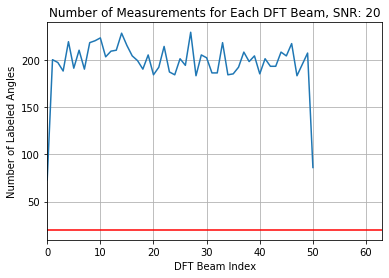

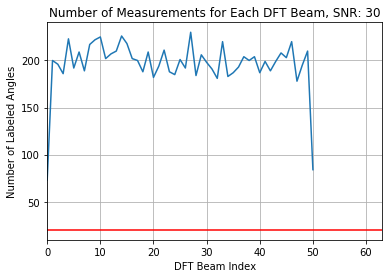

In [70]:
### Load Simulation Data ###
## Dataset Constants
Nr = 36
DATA_SNR = [20, 30]

NUM_DFT = 64                # Number of DFT beams measured
NUM_ANGLES_PER_DFT = 20     # Number of measurements to use for a DFT (per each date; minimum required to be included)
NUM_TOTAL_MEAS = 36         # Number of total PN beam/measurements/features collected (in a file)
NUM_MEAS = 5               # Number of PN beams/measurements/features to use (5, 10, 15 typically) #TODO: NEED TO CHOOSE THE ANGLES SOMEHOW
NUM_PN_COMBO = 1           # Number of random combinations of measurements to run with the algorithm (to ensure the results aren't dependent on beam)(limit NUM_TOTAL_MEAS choose NUM_MEAS)
                            # Set the NUM_PN_COMBO to 1 for the first NUM_MEAS PN beams (i.e. NOT random)
    
DATA_LINEAR_SCALE = True   # Rescale the data from log to linear (pRx is in dB)
DATA_ZERO_MEAN = False      # Offset the data by the mean features of the training data (same offset used for test data)
DATA_NORMALIZATION = True  # Scale the data (training and testing) to the maximum norm of the training data

DATA_DFT_FILESTEM = "../data/nn_sim5/DFT_output_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_dft.csv"
DATA_PN_FILESTEM = "../data/nn_sim5/measurement_RSS_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_pn.csv"
DATA_LABELS_FILESTEM = "../data/nn_sim5/DFT_label_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_labels.csv"
ANGLE_LABEL_FILESTEM = "../data/nn_sim5/label_nr{}_{}dB.csv"

## Computed Constants
NUM_SNRS = len(DATA_SNR)
max_pn_combos = comb(NUM_TOTAL_MEAS, NUM_MEAS)
if (NUM_PN_COMBO > max_pn_combos):
    NUM_PN_COMBO = max_pn_combos.astype(int)

# Compute the PN beams to use for each PN combo set (number of combos = NUM_PN_COMBO)
PN_USE_BEAMS = np.zeros((NUM_PN_COMBO, NUM_MEAS))
if NUM_PN_COMBO > 1:
    # Using more than 1 combo -> randomly choose the combinations of beams
    for pn_i in np.arange(NUM_PN_COMBO):
        PN_USE_BEAMS[pn_i, :] = np.random.choice(NUM_TOTAL_MEAS, NUM_MEAS, replace=False)
elif NUM_PN_COMBO == 1:
    # Using only 1 combo -> Use the first NUM_MEAS beams
    PN_USE_BEAMS[0, :] = np.arange(NUM_MEAS)
else:
    # Invalid number of combos -> error out
    print("INVALID NUMBER OF PN MEASUREMENTS {} -- RERUN WITH A NEW NUMBER".format(NUM_PN_COMBO))
    
PN_USE_BEAMS = PN_USE_BEAMS.astype(int)

## Loop through each test date and determine the data to use
dft_use_all = np.zeros((NUM_SNRS, NUM_DFT))
dft_use_all_num = np.zeros((NUM_SNRS, NUM_DFT))
for snr_ind in np.arange(NUM_SNRS):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)

    ## Pickout the data to use
    u, c = np.unique(df_labels, return_counts=True)
    plt.figure()
    plt.plot(u, c)
    plt.title("Number of Measurements for Each DFT Beam, SNR: {}".format(SNR_i))
    plt.xlabel("DFT Beam Index")
    plt.ylabel("Number of Labeled Angles")
    plt.grid(True)
    plt.xlim(0, 63)
    plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

    # Pick the DFT indices just based on meeting the minimum number of angles required
    dft_valid_mask = u[c >= NUM_ANGLES_PER_DFT].astype(int)
    dft_use_all[snr_ind, dft_valid_mask] = True
    dft_use_all_num[snr_ind, dft_valid_mask] = c[c >= NUM_ANGLES_PER_DFT]
    
pick_dft = np.all(dft_use_all, 0)
dft_use = np.nonzero(pick_dft)[0]
dft_use_num = dft_use_all_num[:,pick_dft].astype(int)
NUM_CLASSES = len(dft_use)
print("Num DFT beams to use: ", NUM_CLASSES)
print("Num samples to use:   ", np.sum(dft_use_num))
print("Num PN beam combos:   ", NUM_PN_COMBO)
if NUM_PN_COMBO == 1:
    print("\tNOT USING RANDOM BEAMS -> FIRST {} PN MEASUREMENTS USED!".format(NUM_MEAS))

In [71]:
# Running dictonaries for the data
train_data_dict = {}
test_data_dict = {}
val_data_dict = {}
train_labels_dict = {}
test_labels_dict = {}
val_labels_dict = {}
train_classes_dict = {}
test_classes_dict = {}
dft_rssi_dict = {}

# The actual loop
for snr_ind in np.arange(NUM_SNRS):
#for date_i in np.arange(NUM_DATES):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)
    arr_pn = df_pn.to_numpy()
    arr_dft = df_dft.to_numpy()

#     ## Pickout the data to use
#     u, c = np.unique(df_labels, return_counts=True)
#     plt.figure()
#     plt.plot(u, c)
#     plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(SNR_i))
#     plt.xlabel("DFT Beam Index")
#     plt.ylabel("Number of Labeled Angles")
#     plt.grid(True)
#     plt.xlim(0, 63)
#     plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

#     # Pick the DFT indices just based on meeting the minimum number of angles required
#     dft_use = u[c >= NUM_ANGLES_PER_DFT].astype(int)
#     dft_use_num = c[c >= NUM_ANGLES_PER_DFT]
    
    # Running dictionary for the data for each PN beam combo
    train_data_datei_dict = {}
    test_data_datei_dict = {}
    #val_data_datei_dict = {}
    train_labels_datei_dict = {}
    test_labels_datei_dict = {}
    #val_labels_datei_dict = {}
    train_classes_datei_dict = {}
    test_classes_datei_dict = {}
    dft_rssi_datei_dict = {}
    
    # Loop through all the PN beam combos
    for pn_i in np.arange(NUM_PN_COMBO):

        # Choose the points randomly from the points available (per each used DFT beam)
        train_data = np.array([])
        train_labels = np.array([])
        test_data = np.array([])
        test_labels = np.array([])
        train_classes = np.array([])
        test_classes = np.array([])
        test_dftrssi = np.array([])
        
        for dft_i in np.arange(len(dft_use)):

            # Find all potential PN beam measurements to use for this DFT beam label
            wh = np.where(df_labels == dft_use[dft_i])
            pn_all_i_temp = arr_pn[wh[0], :]
            pn_all_i = pn_all_i_temp[:,PN_USE_BEAMS[pn_i]]
            dft_all_i = arr_dft[wh[0], :]
            #print("------ PN select size: {}".format(pn_all_i.shape))
#             print(dft_use[dft_i])
#             print(len(wh[0]))
#             print(pn_all_i.shape)

            # Randomly pick the indices to include
            pn_all_ind = np.arange(dft_use_num[snr_ind, dft_i])
            pn_choice_ind = np.random.choice(pn_all_ind, NUM_ANGLES_PER_DFT, replace=False)
            pn_choice = pn_all_i[pn_choice_ind, :]
            pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_ind)
            pn_nchoice = pn_all_i[pn_nchoice_ind, :]
            dft_nchoice = dft_all_i[pn_nchoice_ind, :]
    
            choice_labels = dft_use[dft_i] * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            choice_classes = dft_i * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_classes = dft_i * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            if dft_i == 0:
                train_data = pn_choice
                train_labels = choice_labels
                test_data = pn_nchoice
                test_labels = nchoice_labels
                train_classes = choice_classes
                test_classes = nchoice_classes
                test_dftrssi = dft_nchoice
            else:
                train_data = np.vstack((train_data, pn_choice))
                train_labels = np.vstack((train_labels, choice_labels))
                test_data = np.vstack((test_data, pn_nchoice))
                test_labels = np.vstack((test_labels, nchoice_labels))
                train_classes = np.vstack((train_classes, choice_classes))
                test_classes = np.vstack((test_classes, nchoice_classes))
                test_dftrssi = np.vstack((test_dftrssi, dft_nchoice))
        
        # Store the results in the date dictionary
        print("\t\tTraining data: {}; labels: {}; classes: {} - PN combo {}".format(train_data.shape, train_labels.shape, train_classes.shape, pn_i))
        print("\t\tTesting data:  {}; labels: {}; classes: {} - PN combo {}".format(test_data.shape, test_labels.shape, test_classes.shape, pn_i))
        train_data_datei_dict[pn_i] = train_data
        test_data_datei_dict[pn_i] = test_data
        #val_data_datei_dict[pn_i] = val_data
        train_labels_datei_dict[pn_i] = train_labels.astype(int)
        test_labels_datei_dict[pn_i] = test_labels.astype(int)
        #val_labels_datei_dict[pn_i] = val_labels
        train_classes_datei_dict[pn_i] = train_classes.astype(int)
        test_classes_datei_dict[pn_i] = test_classes.astype(int)
        
        # Save the DFT beam RSSI for future gain loss performance evaluation
        dft_rssi_datei_dict[pn_i] = test_dftrssi
        
    # Store the results in the overall dictionaries
    print("\tTraining dictionaries - data: {}; labels: {}; classes: {}".format(len(train_data_datei_dict), len(train_labels_datei_dict), len(train_classes_datei_dict)))
    print("\tTesting dictionaries - data:  {}; labels: {}; classes: {}".format(len(test_data_datei_dict), len(test_labels_datei_dict), len(test_classes_datei_dict)))
    train_data_dict[SNR_i] = train_data_datei_dict
    test_data_dict[SNR_i] = test_data_datei_dict
    #val_data_dict[SNR_i] = val_data_datei_dict
    train_labels_dict[SNR_i] = train_labels_datei_dict
    test_labels_dict[SNR_i] = test_labels_datei_dict
    #val_labels_dict[SNR_i] = val_labels_datei_dict
    train_classes_dict[SNR_i] = train_classes_datei_dict
    test_classes_dict[SNR_i] = test_classes_datei_dict
    dft_rssi_dict[SNR_i] = dft_rssi_datei_dict
    
## Final variable cleanup
train_data_all = {}
train_labels_all = {}
train_classes_all = {}
# val_data_all = {}
# val_labels_all = {}
# val_classes_all = {}
test_data_all = {}
test_labels_all = {}
test_classes_all = {}
test_dftrssi_all = {}

print("\nCreating total training/validation/test datasets:")
for pn_i in np.arange(NUM_PN_COMBO):
    # Running variables
    train_data_pni = np.array([])
    train_labels_pni = np.array([])
    train_classes_pni = np.array([])
    # val_data_pni = np.array([])
    # val_labels_pni = np.array([])
    # val_classes_pni = np.array([])
    test_data_pni = np.array([])
    test_labels_pni = np.array([])
    test_classes_pni = np.array([])
    test_dftrssi_pni = np.array([])
    importeddata = False
    
    # Combine the data for each set of PN beams/measurements
    for snr_i in np.arange(len(train_data_dict)):
        #print("\ttrain: {}, val: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape, val_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        print("\ttrain: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        if not importeddata:
            train_data_pni = train_data_dict[DATA_SNR[snr_i]][pn_i]
            train_labels_pni = train_labels_dict[DATA_SNR[snr_i]][pn_i]
            train_classes_pni = train_classes_dict[DATA_SNR[snr_i]][pn_i]
    #         val_data_pni = val_data_dict[DATA_SNR[snr_i]][pn_i]
    #         val_labels_pni = val_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_data_pni = test_data_dict[DATA_SNR[snr_i]][pn_i]
            test_labels_pni = test_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_classes_pni = test_classes_dict[DATA_SNR[snr_i]][pn_i]
            test_dftrssi_pni = dft_rssi_dict[DATA_SNR[snr_i]][pn_i]
            importeddata = True
        else:
            train_data_pni = np.vstack((train_data_pni, train_data_dict[DATA_SNR[snr_i]][pn_i]))
            train_labels_pni = np.vstack((train_labels_pni, train_labels_dict[DATA_SNR[snr_i]][pn_i]))
            train_classes_pni = np.vstack((train_classes_pni, train_classes_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_data_pni = np.vstack((val_data_pni, val_data_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_labels_pni = np.vstack((val_labels_pni, val_labels_dict[DATA_SNRR[snr_i]][pn_i]))
            test_data_pni = np.vstack((test_data_pni, test_data_dict[DATA_SNR[snr_i]][pn_i]))
            test_labels_pni = np.vstack((test_labels_pni, test_labels_dict[DATA_SNR[snr_i]][pn_i]))
            test_classes_pni = np.vstack((test_classes_pni, test_classes_dict[DATA_SNR[snr_i]][pn_i]))
            test_dftrssi_pni = np.vstack((test_dftrssi_pni, dft_rssi_dict[DATA_SNR[snr_i]][pn_i]))
    
    # Store the combined data for this set of features into the overall dictionary
    train_data_all[pn_i] = train_data_pni
    train_labels_all[pn_i] = train_labels_pni
    train_classes_all[pn_i] = train_classes_pni
    test_data_all[pn_i] = test_data_pni
    test_labels_all[pn_i] = test_labels_pni
    test_classes_all[pn_i] = test_classes_pni
    test_dftrssi_all[pn_i] = test_dftrssi_pni

## Data scaling and normalization
print("\nRunning data scaling and normalization...")
NUM_TRAIN = np.zeros((NUM_PN_COMBO, 1))
for pn_i in np.arange(NUM_PN_COMBO):
    print("\tTraining data range: ({}, {}) --- PN set {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i]), pn_i))
    if DATA_LINEAR_SCALE:
        print("\t\tUsing linear scale data...")
        train_data_all[pn_i] = 10**(train_data_all[pn_i]/10)
        test_data_all[pn_i] = 10**(test_data_all[pn_i]/10)
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = 10**(test_data_dict[DATA_SNR[snr_i]][pn_i]/10)

    if DATA_ZERO_MEAN:
        train_mean = np.mean(train_data_all[pn_i], 0)
        print("\t\tUsing zero-mean offset; offset by {}...".format(train_mean))
        train_data_all[pn_i] = train_data_all[pn_i] - train_mean
        test_data_all[pn_i] = test_data_all[pn_i] - train_mean
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i] - train_mean

    if DATA_NORMALIZATION:
        data_scale = np.max(np.linalg.norm(train_data_all[pn_i], 2, 1))
        print("\t\tData scale factor (max norm): {}...".format(data_scale))
        train_data_all[pn_i] = train_data_all[pn_i]/data_scale
        test_data_all[pn_i] = test_data_all[pn_i]/data_scale
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i]/data_scale
        print("\t\tNew training data range: {}, {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i])))

    NUM_TRAIN[pn_i] = int(train_data_all[pn_i].shape[0])
    print("\t\tTotal training dataset size (PN set {}): {}".format(pn_i, train_data_all[pn_i].shape))
    print("\t\tTotal test dataset size     (PN set {}): {}".format(pn_i, test_data_all[pn_i].shape))
    # NUM_VAL = int(val_data_all.shape[0])
    # print("Total validation dataset size: {}".format(val_data_all.shape))
    
# Save the total test data to a new dictionary key (useful for test loops)
test_data_dict['ALL'] = test_data_all
test_labels_dict['ALL'] = test_labels_all
test_classes_dict['ALL'] = test_classes_all
dft_rssi_dict['ALL'] = test_dftrssi_all

Nr: 36, SNR: 20
	DFT data:  (10000, 51)
	PN data:   (10000, 36)
	Labels:    (10000, 1)
		Training data: (1020, 5); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (8980, 5); labels: (8980, 1); classes: (8980, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Nr: 36, SNR: 30
	DFT data:  (10000, 51)
	PN data:   (10000, 36)
	Labels:    (10000, 1)
		Training data: (1020, 5); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (8980, 5); labels: (8980, 1); classes: (8980, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1

Creating total training/validation/test datasets:
	train: (1020, 5)
	train: (1020, 5)

Running data scaling and normalization...
	Training data range: (0.009650399999999998, 2.4809) --- PN set 0
		Using linear scale data...
		Data scale factor (max norm): 3.0890406353386077...
		New t

# Classification Method - Only Discrete Beams Considered
Beam training can be thought of as a classification problem; optimize for the best training beam/code quickly (one shot or a few shots).  Compressive sensing methods are able to reduce the number of training beams required to predict the AoA, but ML methods might improve on this.

In [5]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
all_test_acc = {}
all_confusionMat = {}
all_RMSE_disc = {}
all_RMSE_cont = {}
all_pe_byLabel = {}
all_gainLoss = {}
GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)

data_scale = 1

# Custom loss function
def cLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))


In [6]:
### Dictionaries to hold metrics for different runs ###
# Keys: Number of features used to train
class_test_acc = {}
class_confusionMat = {}
class_RMSE_disc = {}
class_RMSE_cont = {}


### NN for 36 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 682us/sample - loss: 1.7628 - sparse_categorical_accuracy: 0.6475
Epoch 2/75
2040/2040 [==============================] - 0s 81us/sample - loss: 0.4170 - sparse_categorical_accuracy: 0.9230
Epoch 3/75
2040/2040 [==============================] - 0s 83us/sample - loss: 0.2268 - sparse_categorical_accuracy: 0.9446
Epoch 4/75
2040/2040 [==============================] - 0s 79us/sample - loss: 0.1797 - sparse_categorical_accuracy: 0.9436
Epoch 5/75
2040/2040 [==============================] - 0s 80us/sample - loss: 0.1593 - sparse_categorical_accuracy: 0.9436
Epoch 6/75
2040/2040 [==============================] - 0s 80us/sample - loss: 0.1355 - sparse_categorical_accuracy: 0.9495
Epoch 7/75
2040/2040 [==============================] - 0s 78us/sample - loss: 0.1352 - sparse_categorical_accuracy: 0.9500
Epoch 8/75
2040/2040 [==============================] - 0s 80us/sample - lo

Text(0.5, 0, 'Epoch')

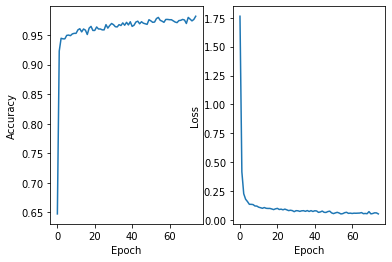

In [7]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2285 - sparse_categorical_accuracy: 0.9295
	Test accuracy: 0.92951


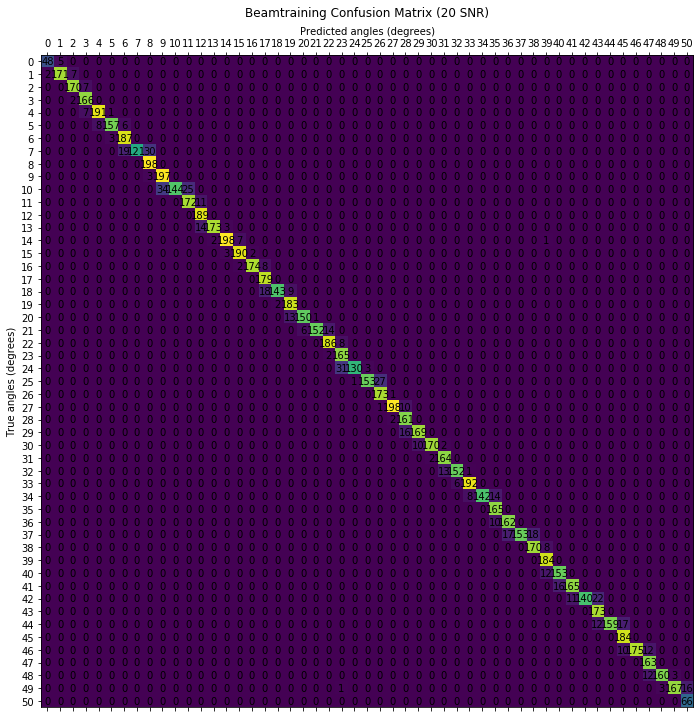

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1945 - sparse_categorical_accuracy: 0.9360
	Test accuracy: 0.9359688


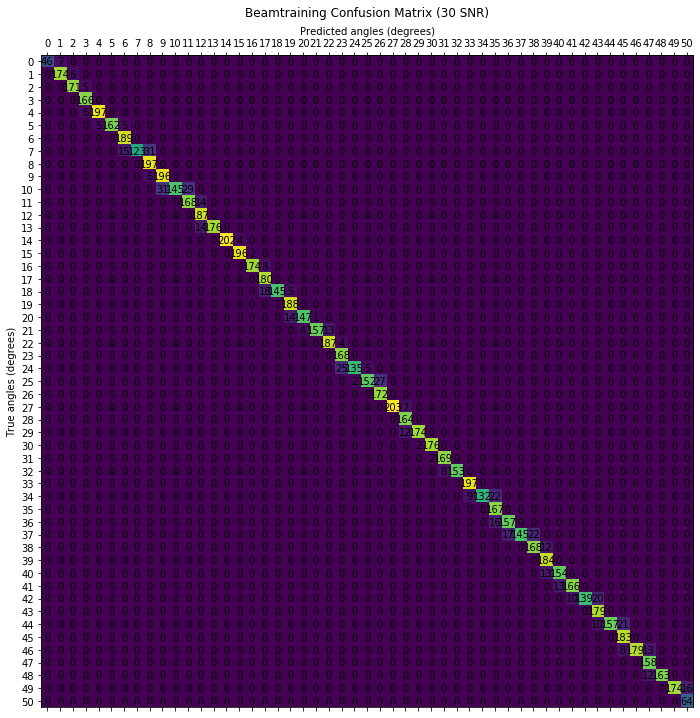

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2115 - sparse_categorical_accuracy: 0.9327
	Test accuracy: 0.93273944


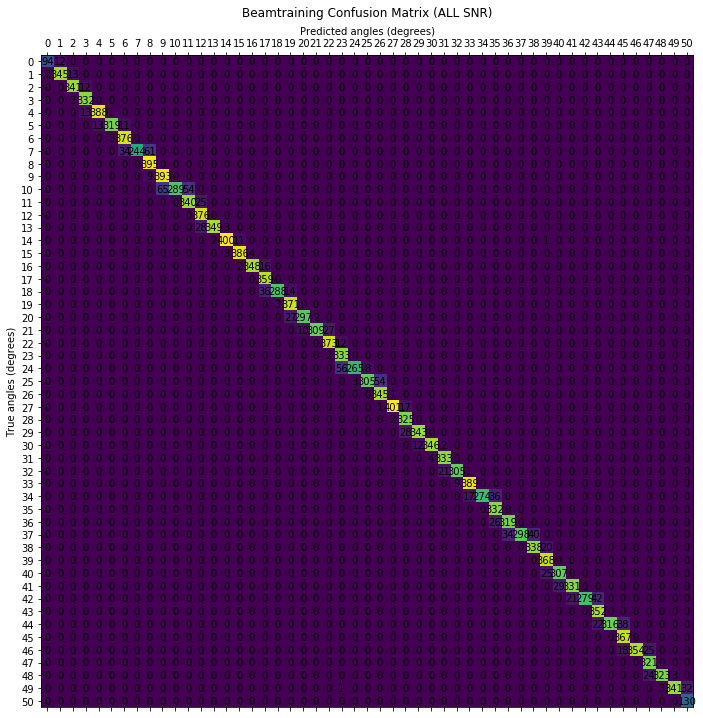


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     39.062]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.      1.597]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     39.062]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9295099973678589
	SNR: 30; Accuracy: 0.935968816280365


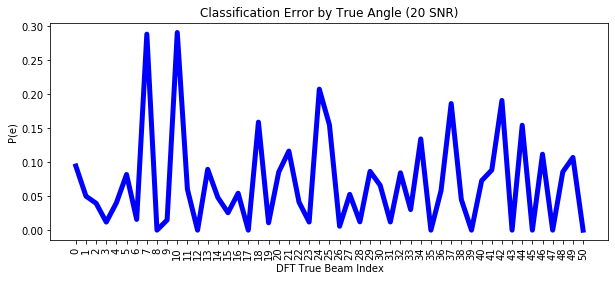

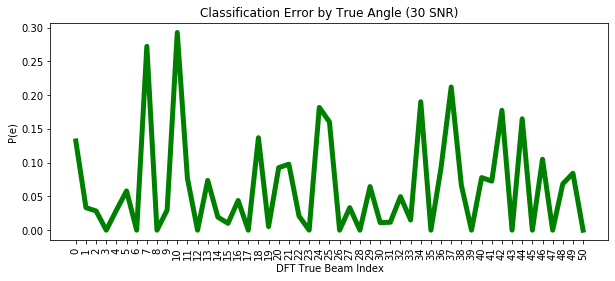

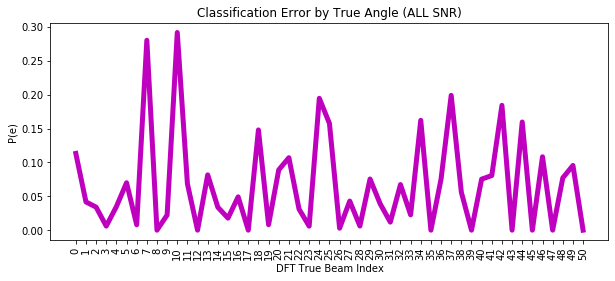

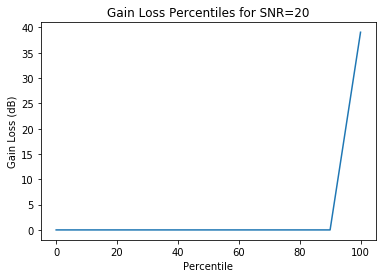

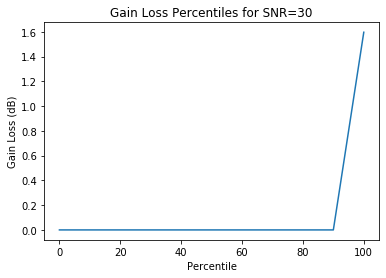

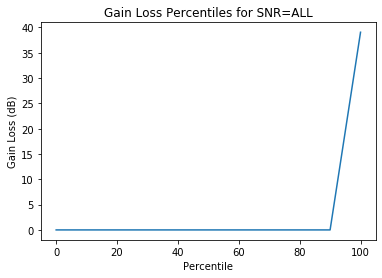

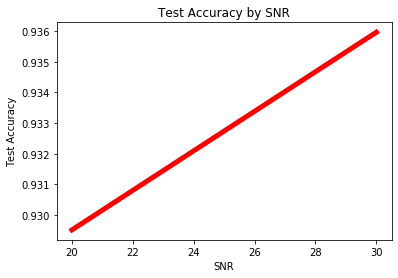

In [8]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 20 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 507us/sample - loss: 1.6867 - sparse_categorical_accuracy: 0.6490
Epoch 2/75
2040/2040 [==============================] - 0s 117us/sample - loss: 0.3864 - sparse_categorical_accuracy: 0.9113
Epoch 3/75
2040/2040 [==============================] - 0s 121us/sample - loss: 0.2453 - sparse_categorical_accuracy: 0.9235
Epoch 4/75
2040/2040 [==============================] - 0s 123us/sample - loss: 0.2117 - sparse_categorical_accuracy: 0.9294
Epoch 5/75
2040/2040 [==============================] - 0s 117us/sample - loss: 0.1856 - sparse_categorical_accuracy: 0.9319
Epoch 6/75
2040/2040 [==============================] - 0s 119us/sample - loss: 0.1735 - sparse_categorical_accuracy: 0.9304
Epoch 7/75
2040/2040 [==============================] - 0s 126us/sample - loss: 0.1650 - sparse_categorical_accuracy: 0.9328
Epoch 8/75
2040/2040 [==============================] - 0s 122us/samp

Text(0.5, 0, 'Epoch')

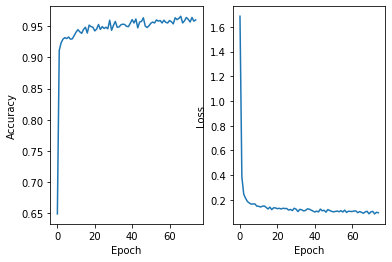

In [11]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3298 - sparse_categorical_accuracy: 0.9154
	Test accuracy: 0.9153675


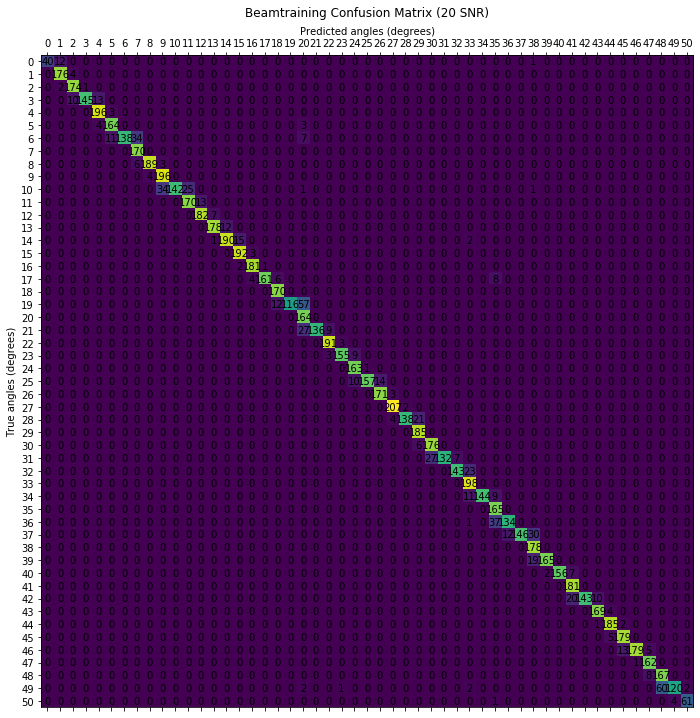

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2915 - sparse_categorical_accuracy: 0.9233
	Test accuracy: 0.9232739


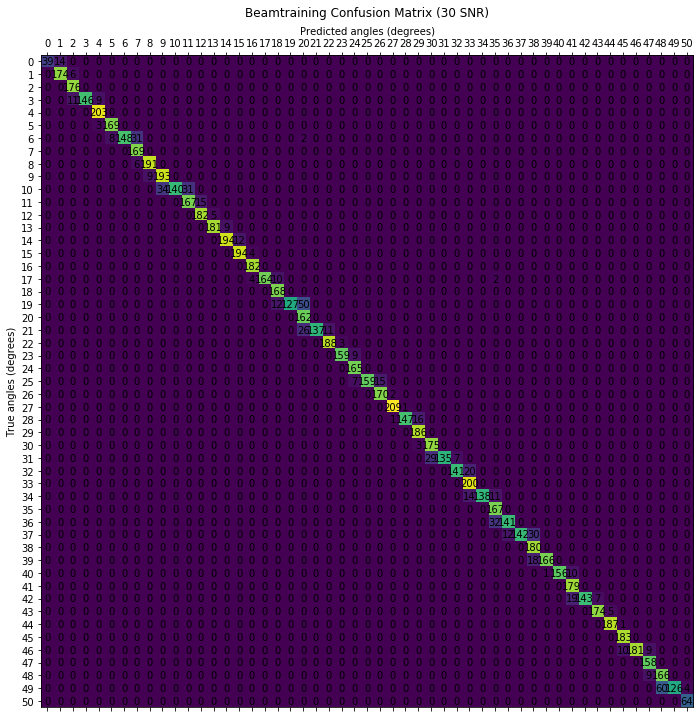

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.3106 - sparse_categorical_accuracy: 0.9193
	Test accuracy: 0.9193207


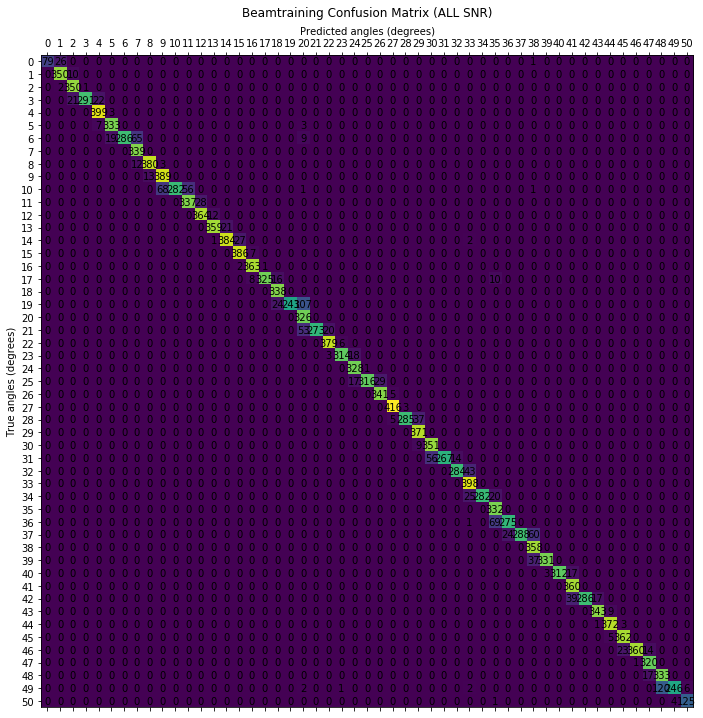


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     46.628]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     34.386]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     46.628]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9153674840927124
	SNR: 30; Accuracy: 0.9232739210128784


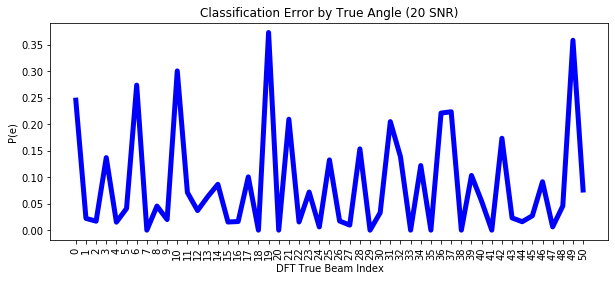

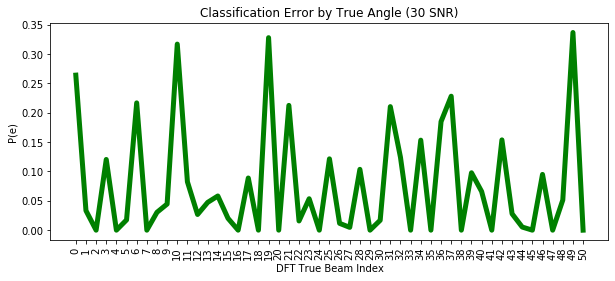

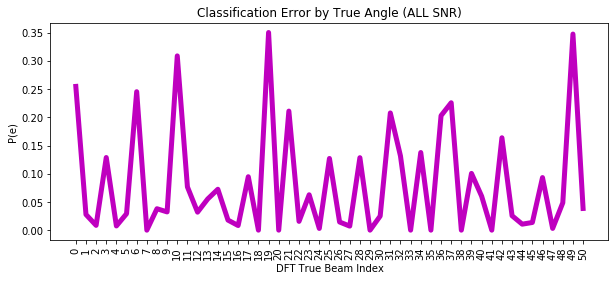

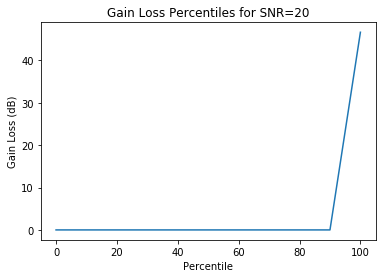

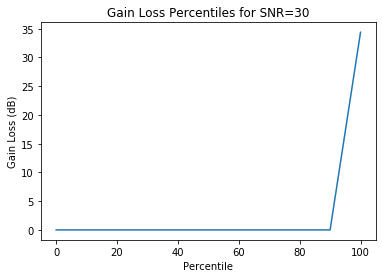

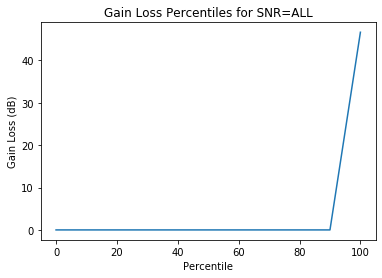

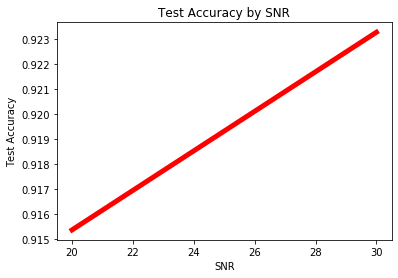

In [12]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 16 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 509us/sample - loss: 1.7681 - sparse_categorical_accuracy: 0.6235
Epoch 2/75
2040/2040 [==============================] - 0s 184us/sample - loss: 0.4416 - sparse_categorical_accuracy: 0.9074
Epoch 3/75
2040/2040 [==============================] - 0s 184us/sample - loss: 0.2829 - sparse_categorical_accuracy: 0.9132
Epoch 4/75
2040/2040 [==============================] - 0s 185us/sample - loss: 0.2283 - sparse_categorical_accuracy: 0.9225
Epoch 5/75
2040/2040 [==============================] - 0s 186us/sample - loss: 0.2005 - sparse_categorical_accuracy: 0.9235
Epoch 6/75
2040/2040 [==============================] - 0s 185us/sample - loss: 0.1820 - sparse_categorical_accuracy: 0.9304
Epoch 7/75
2040/2040 [==============================] - 0s 183us/sample - loss: 0.1707 - sparse_categorical_accuracy: 0.9377
Epoch 8/75
2040/2040 [==============================] - 0s 187us/samp

Text(0.5, 0, 'Epoch')

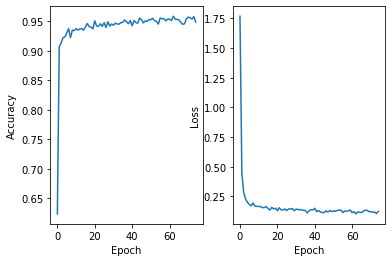

In [64]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2441 - sparse_categorical_accuracy: 0.9220
	Test accuracy: 0.922049


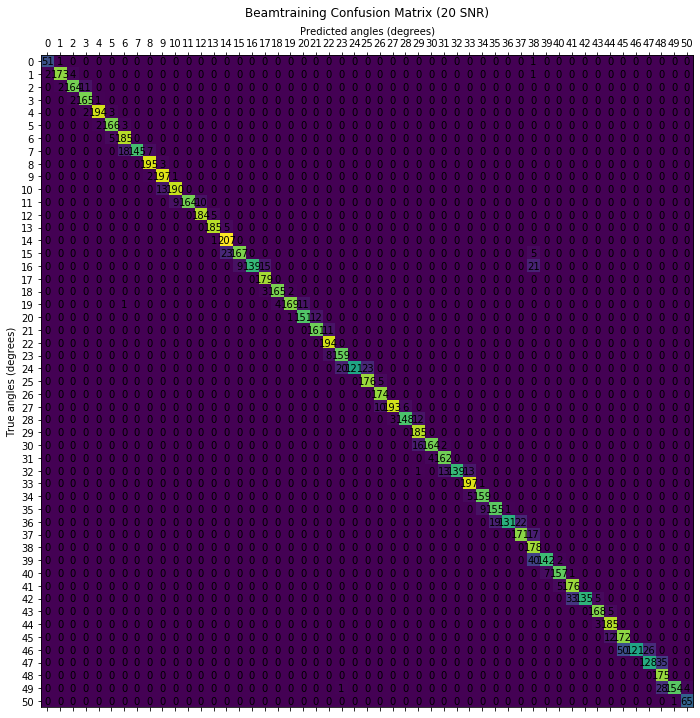

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1901 - sparse_categorical_accuracy: 0.9337
	Test accuracy: 0.9337416


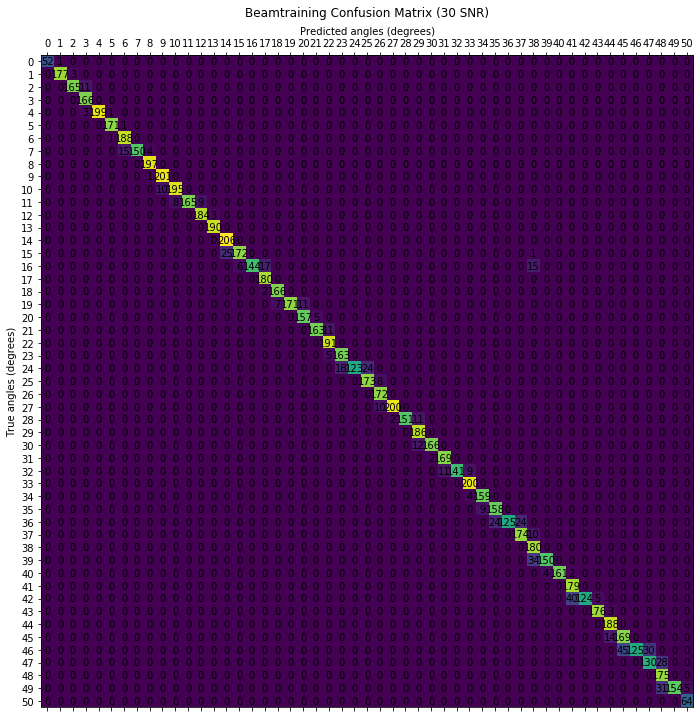

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2171 - sparse_categorical_accuracy: 0.9279
	Test accuracy: 0.9278953


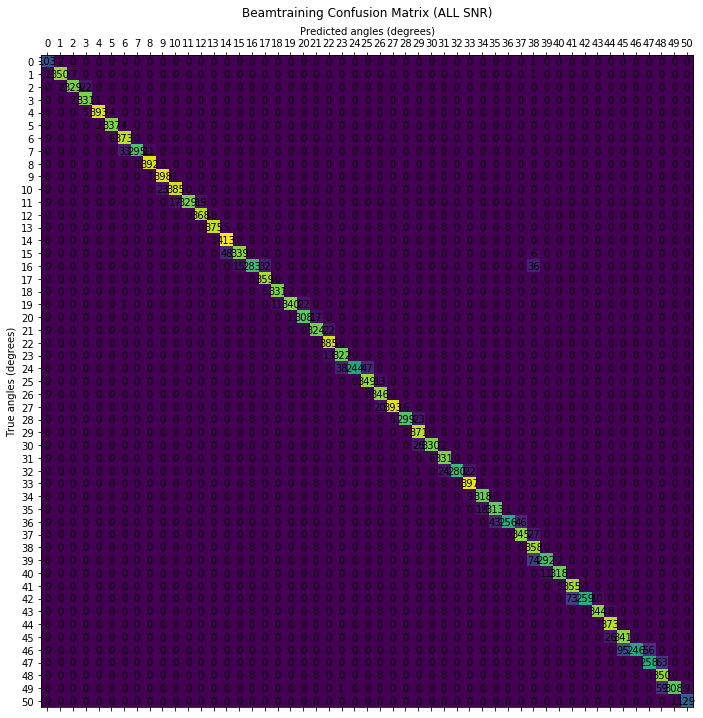


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     48.438]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     41.657]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     48.438]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9220489859580994
	SNR: 30; Accuracy: 0.9337416291236877


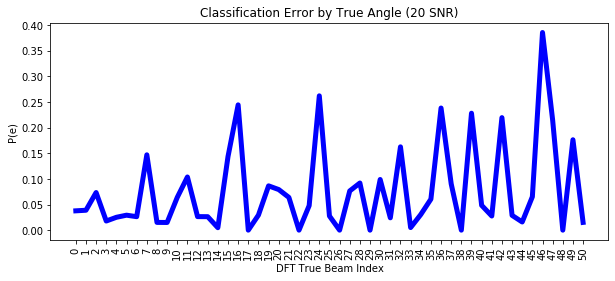

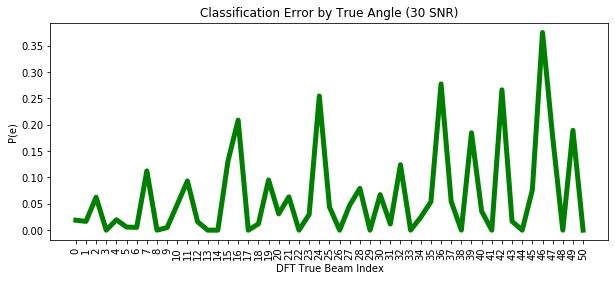

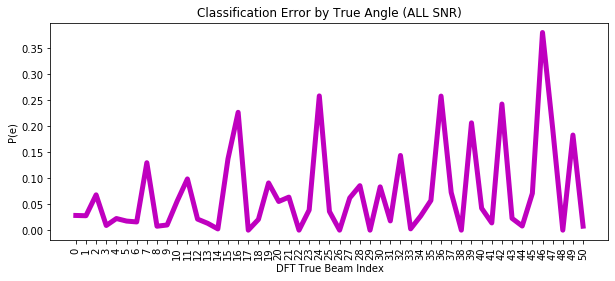

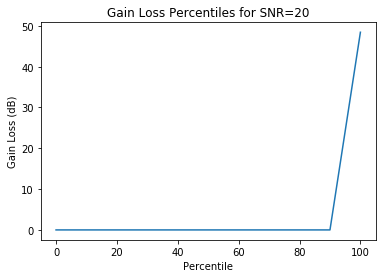

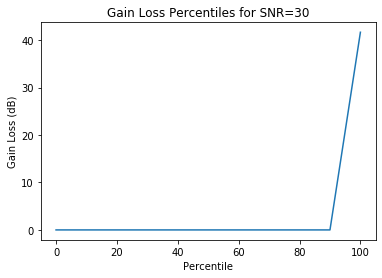

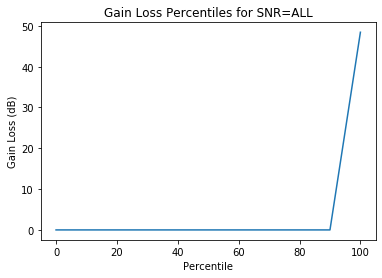

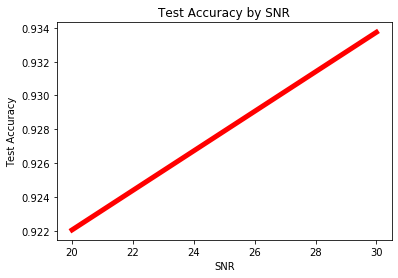

In [65]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 15 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 461us/sample - loss: 1.5928 - sparse_categorical_accuracy: 0.6632
Epoch 2/75
2040/2040 [==============================] - 0s 148us/sample - loss: 0.4259 - sparse_categorical_accuracy: 0.8956
Epoch 3/75
2040/2040 [==============================] - 0s 149us/sample - loss: 0.2886 - sparse_categorical_accuracy: 0.9029
Epoch 4/75
2040/2040 [==============================] - 0s 155us/sample - loss: 0.2274 - sparse_categorical_accuracy: 0.9235
Epoch 5/75
2040/2040 [==============================] - 0s 161us/sample - loss: 0.2084 - sparse_categorical_accuracy: 0.9216
Epoch 6/75
2040/2040 [==============================] - 0s 156us/sample - loss: 0.1997 - sparse_categorical_accuracy: 0.9250
Epoch 7/75
2040/2040 [==============================] - 0s 156us/sample - loss: 0.1903 - sparse_categorical_accuracy: 0.9275
Epoch 8/75
2040/2040 [==============================] - 0s 169us/samp

Text(0.5, 0, 'Epoch')

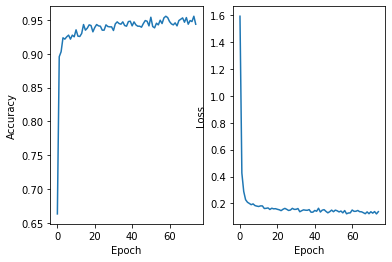

In [15]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2396 - sparse_categorical_accuracy: 0.9236
	Test accuracy: 0.923608


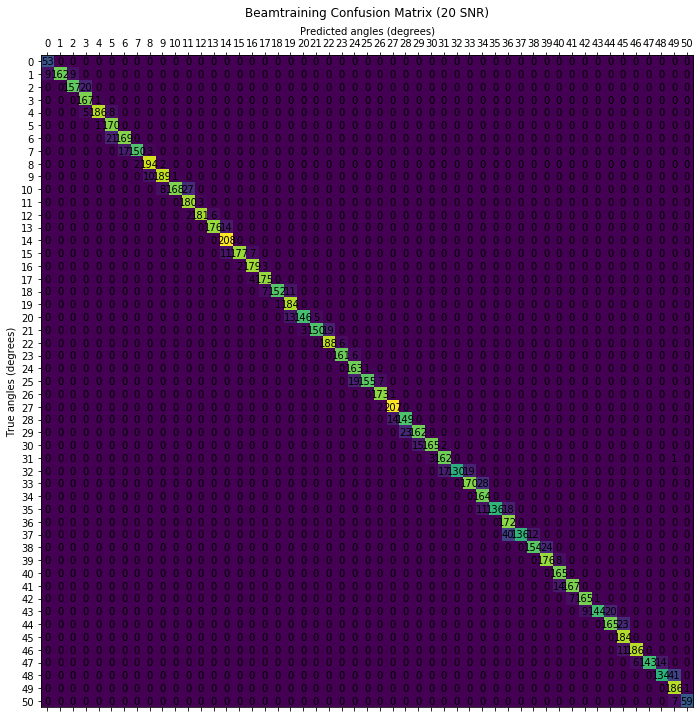

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1926 - sparse_categorical_accuracy: 0.9327
	Test accuracy: 0.93273944


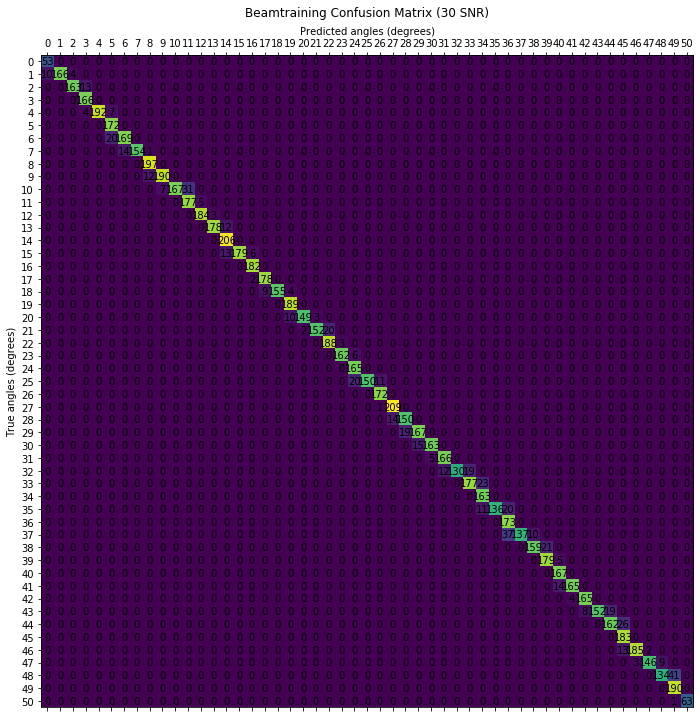

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2161 - sparse_categorical_accuracy: 0.9282
	Test accuracy: 0.9281737


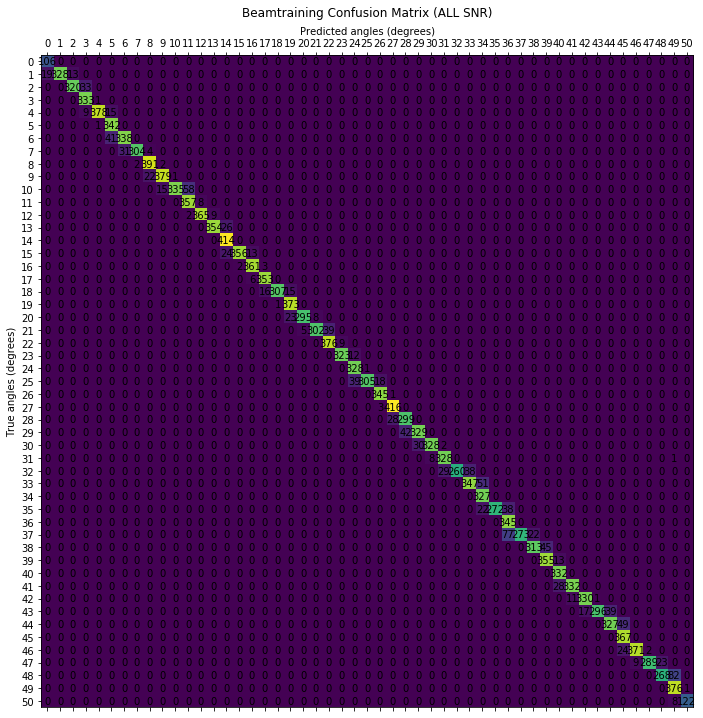


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     33.871]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.      1.266]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     33.871]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9236080050468445
	SNR: 30; Accuracy: 0.9327394366264343


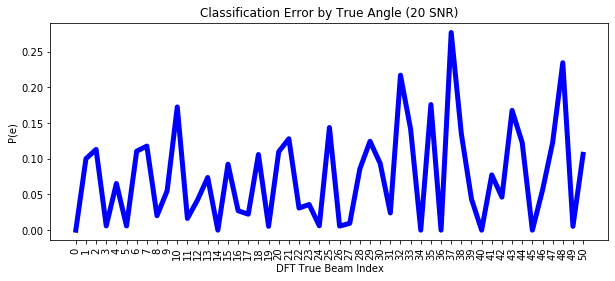

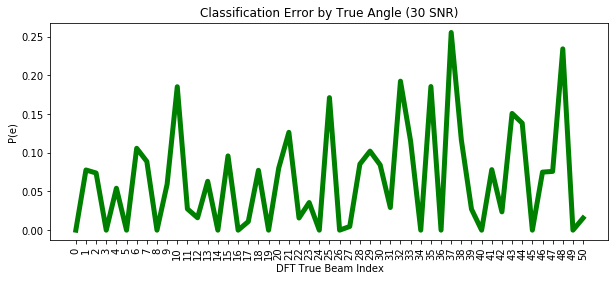

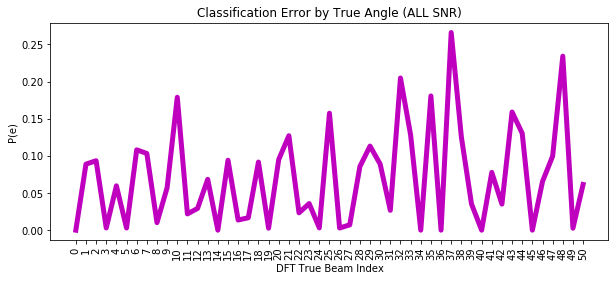

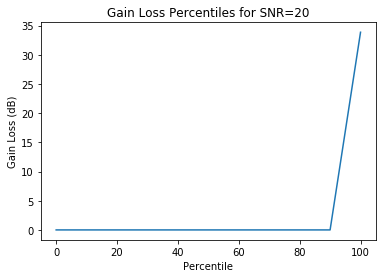

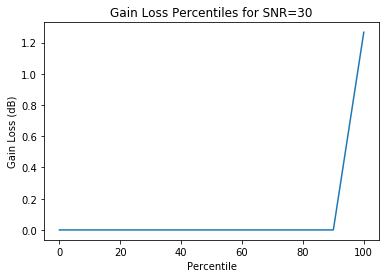

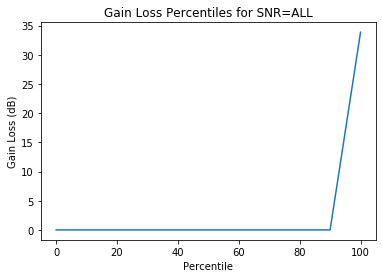

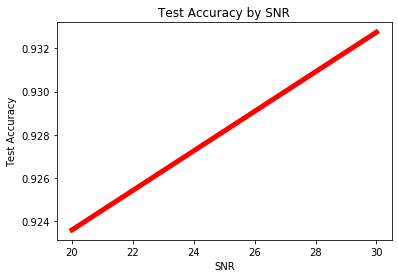

In [16]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 12 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 527us/sample - loss: 1.5215 - sparse_categorical_accuracy: 0.6760
Epoch 2/75
2040/2040 [==============================] - 0s 229us/sample - loss: 0.4417 - sparse_categorical_accuracy: 0.8951
Epoch 3/75
2040/2040 [==============================] - 0s 190us/sample - loss: 0.3163 - sparse_categorical_accuracy: 0.9064
Epoch 4/75
2040/2040 [==============================] - 0s 185us/sample - loss: 0.2631 - sparse_categorical_accuracy: 0.9137
Epoch 5/75
2040/2040 [==============================] - 0s 207us/sample - loss: 0.2429 - sparse_categorical_accuracy: 0.9181
Epoch 6/75
2040/2040 [==============================] - 0s 202us/sample - loss: 0.2239 - sparse_categorical_accuracy: 0.9181
Epoch 7/75
2040/2040 [==============================] - 0s 194us/sample - loss: 0.1973 - sparse_categorical_accuracy: 0.9319
Epoch 8/75
2040/2040 [==============================] - 0s 195us/samp

Text(0.5, 0, 'Epoch')

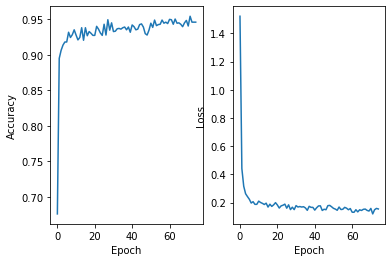

In [19]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 1s - loss: 0.3308 - sparse_categorical_accuracy: 0.9068
	Test accuracy: 0.9067929


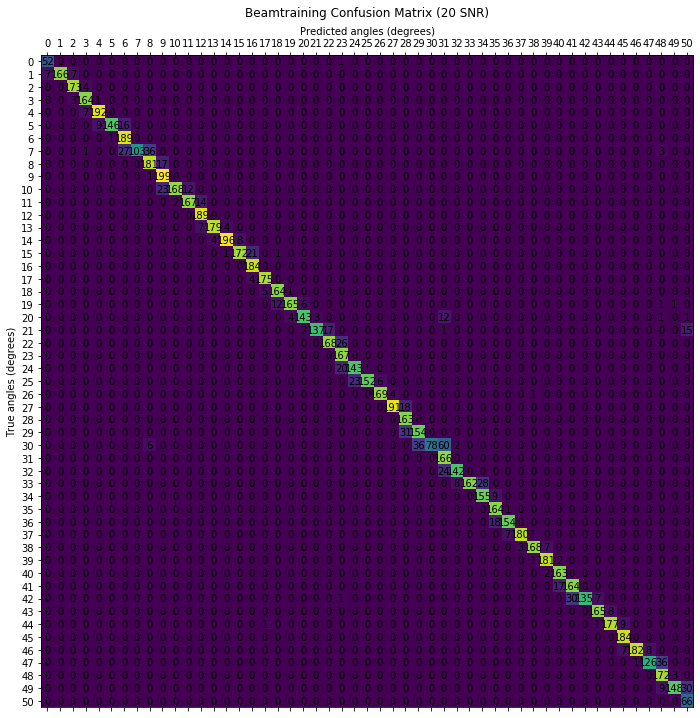

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2807 - sparse_categorical_accuracy: 0.9150
	Test accuracy: 0.9150334


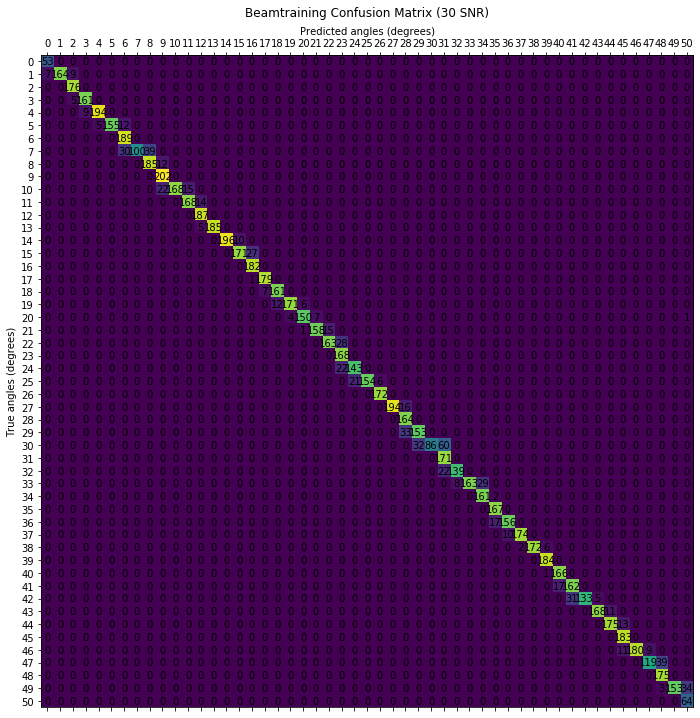

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.3058 - sparse_categorical_accuracy: 0.9109
	Test accuracy: 0.91091317


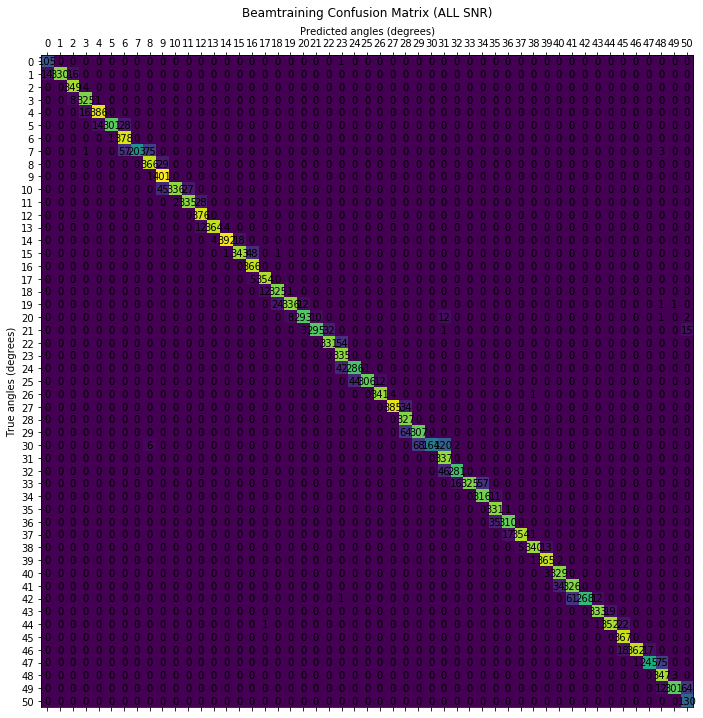


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     47.564]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     31.394]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     47.564]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9067928791046143
	SNR: 30; Accuracy: 0.9150334000587463


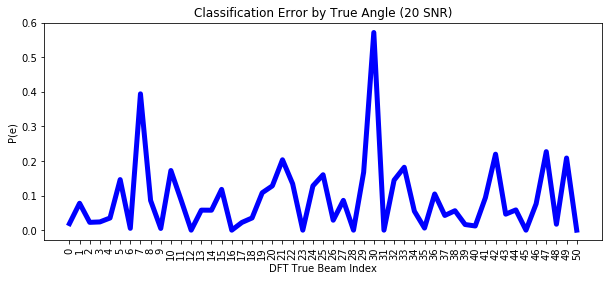

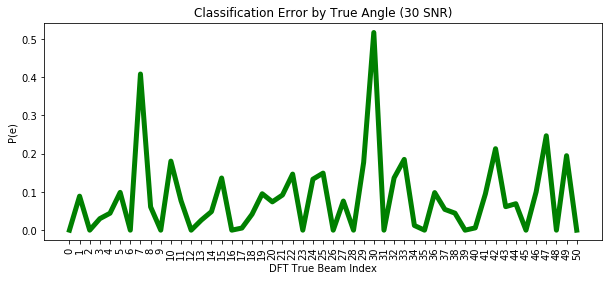

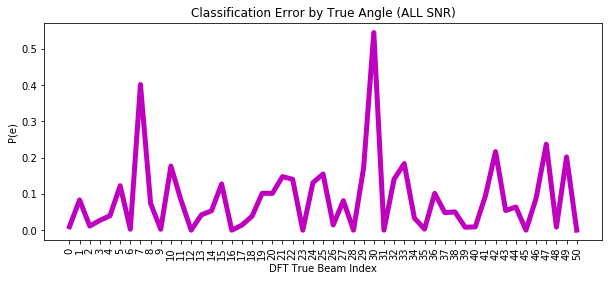

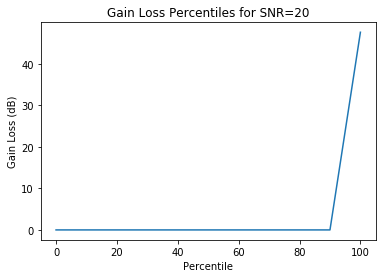

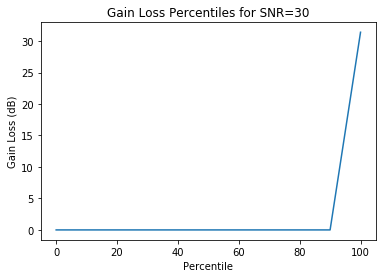

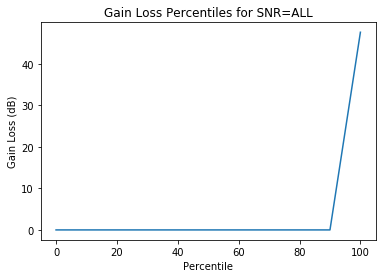

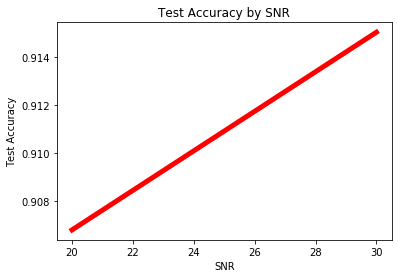

In [20]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 10 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 542us/sample - loss: 1.7253 - sparse_categorical_accuracy: 0.6167
Epoch 2/75
2040/2040 [==============================] - 0s 226us/sample - loss: 0.5987 - sparse_categorical_accuracy: 0.8613
Epoch 3/75
2040/2040 [==============================] - 0s 229us/sample - loss: 0.3957 - sparse_categorical_accuracy: 0.8892
Epoch 4/75
2040/2040 [==============================] - 0s 222us/sample - loss: 0.3513 - sparse_categorical_accuracy: 0.8868
Epoch 5/75
2040/2040 [==============================] - 0s 232us/sample - loss: 0.3175 - sparse_categorical_accuracy: 0.8990
Epoch 6/75
2040/2040 [==============================] - 0s 225us/sample - loss: 0.3027 - sparse_categorical_accuracy: 0.8971
Epoch 7/75
2040/2040 [==============================] - 0s 228us/sample - loss: 0.3010 - sparse_categorical_accuracy: 0.8946
Epoch 8/75
2040/2040 [==============================] - 0s 228us/samp

Text(0.5, 0, 'Epoch')

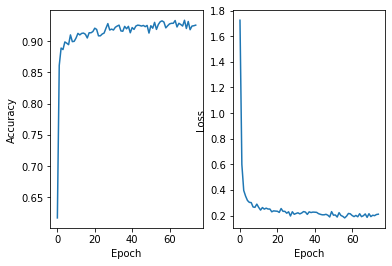

In [23]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2991 - sparse_categorical_accuracy: 0.9099
	Test accuracy: 0.9099109


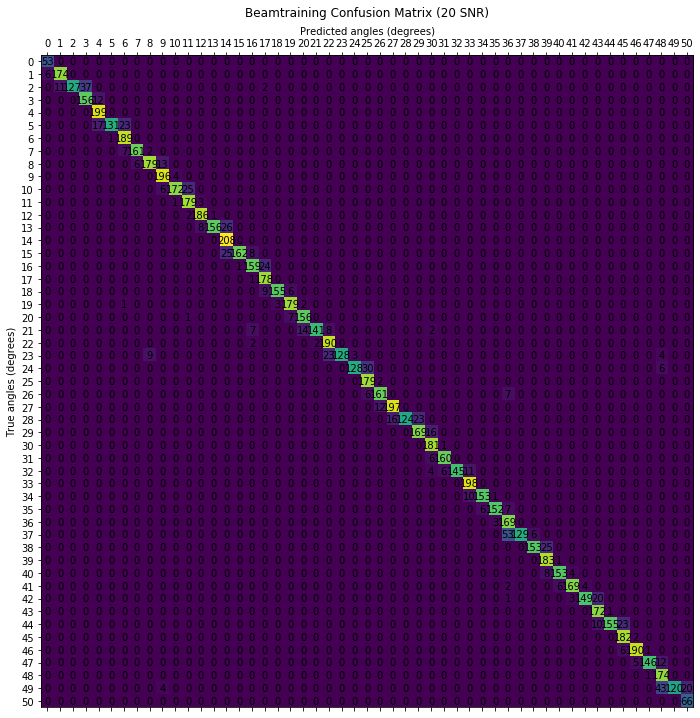

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2522 - sparse_categorical_accuracy: 0.9215
	Test accuracy: 0.9214922


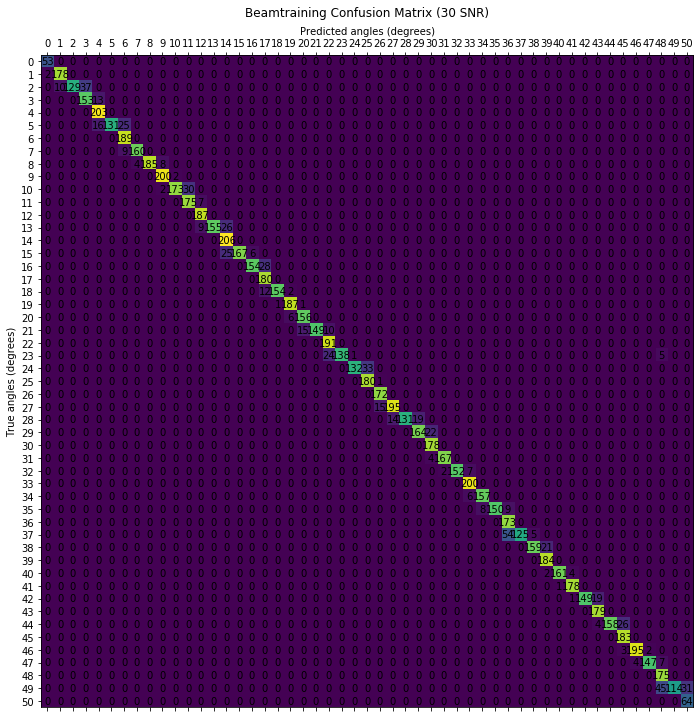

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2757 - sparse_categorical_accuracy: 0.9157
	Test accuracy: 0.91570157


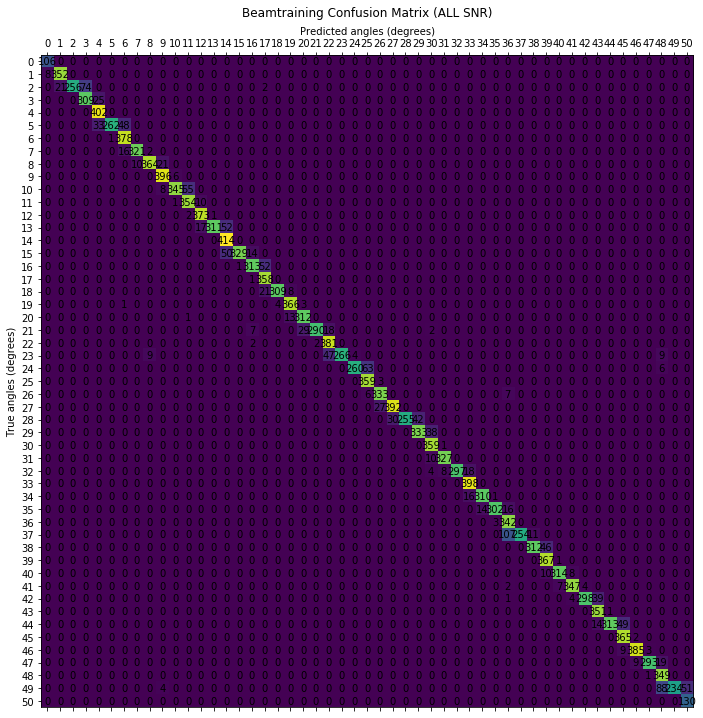


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     50.116]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     38.649]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     50.116]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9099109172821045
	SNR: 30; Accuracy: 0.9214922189712524


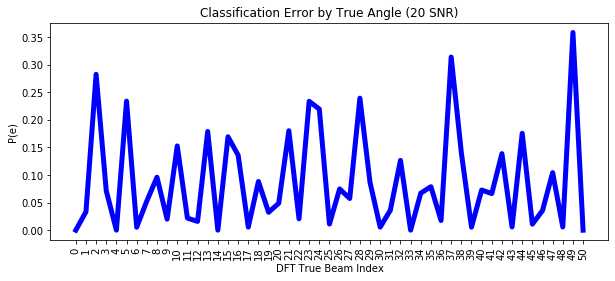

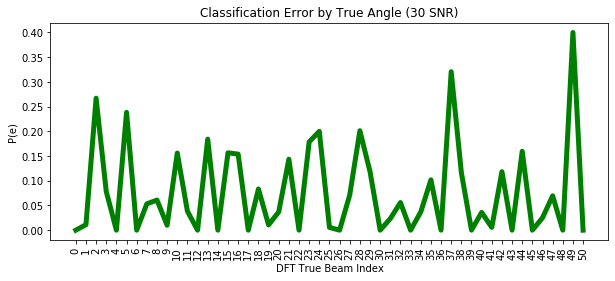

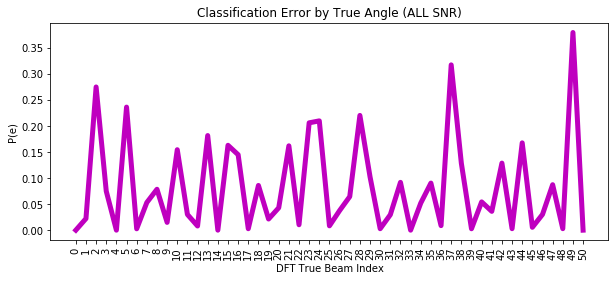

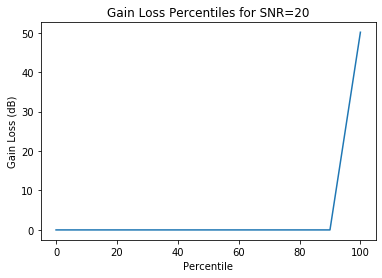

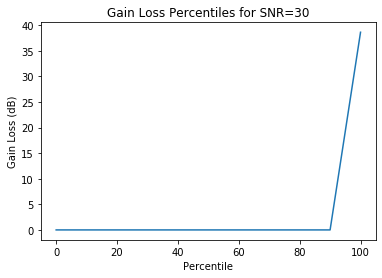

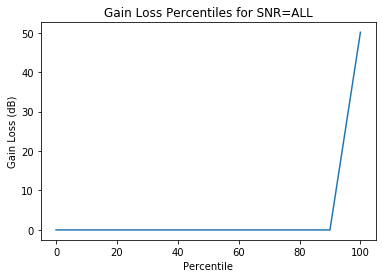

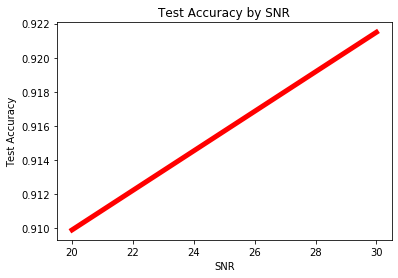

In [24]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 9 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 650us/sample - loss: 1.6852 - sparse_categorical_accuracy: 0.6309
Epoch 2/75
2040/2040 [==============================] - 1s 330us/sample - loss: 0.6895 - sparse_categorical_accuracy: 0.8343
Epoch 3/75
2040/2040 [==============================] - 1s 325us/sample - loss: 0.5122 - sparse_categorical_accuracy: 0.8578
Epoch 4/75
2040/2040 [==============================] - 1s 325us/sample - loss: 0.4117 - sparse_categorical_accuracy: 0.8730
Epoch 5/75
2040/2040 [==============================] - 1s 326us/sample - loss: 0.4182 - sparse_categorical_accuracy: 0.8603
Epoch 6/75
2040/2040 [==============================] - 1s 332us/sample - loss: 0.3590 - sparse_categorical_accuracy: 0.8794
Epoch 7/75
2040/2040 [==============================] - 1s 330us/sample - loss: 0.3715 - sparse_categorical_accuracy: 0.8745
Epoch 8/75
2040/2040 [==============================] - 1s 331us/samp

Text(0.5, 0, 'Epoch')

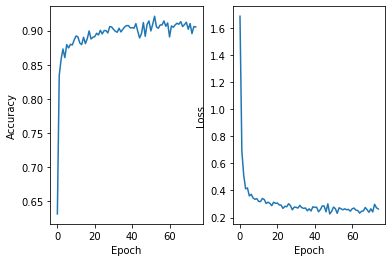

In [27]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3780 - sparse_categorical_accuracy: 0.8801
	Test accuracy: 0.8800668


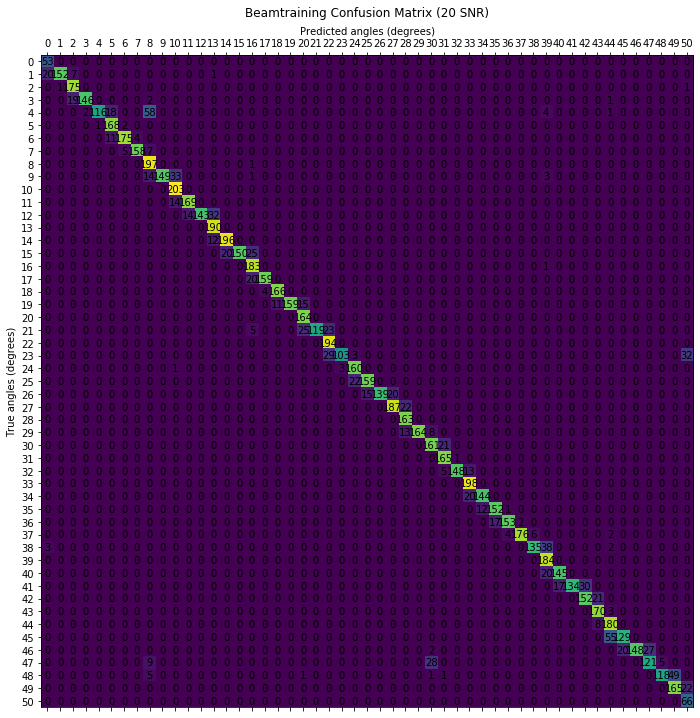

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3114 - sparse_categorical_accuracy: 0.8904
	Test accuracy: 0.8904232


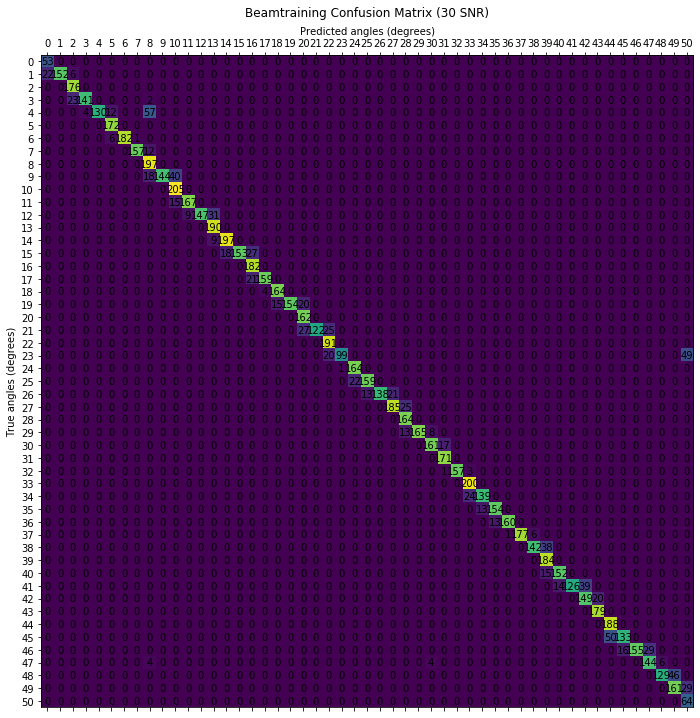

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.3447 - sparse_categorical_accuracy: 0.8852
	Test accuracy: 0.88524497


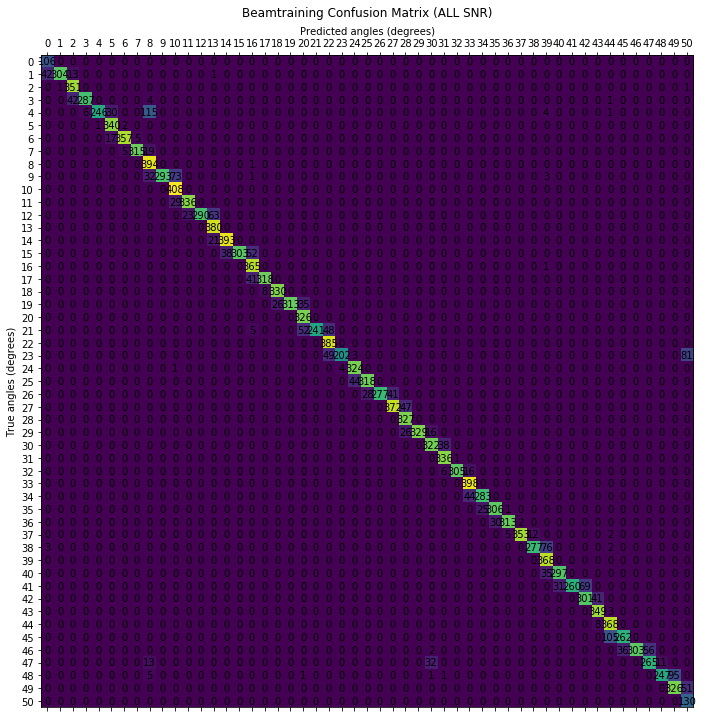


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.154]
 [100.     53.773]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 6.9000e-02]
 [1.0000e+02 4.9292e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.108]
 [100.     53.773]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.88006681203

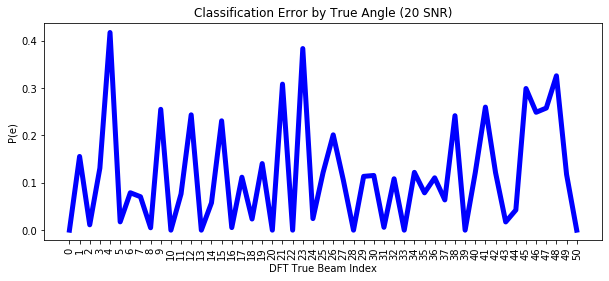

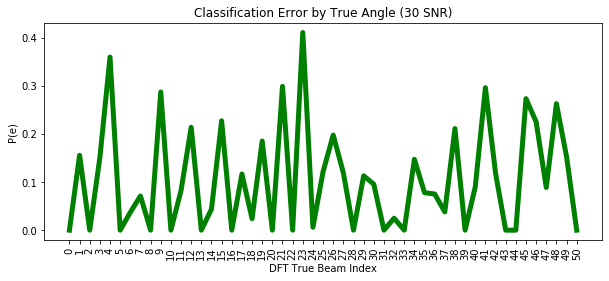

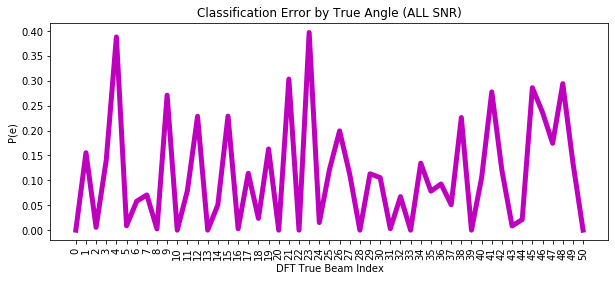

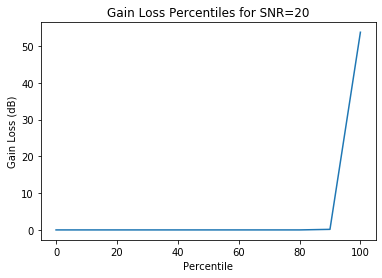

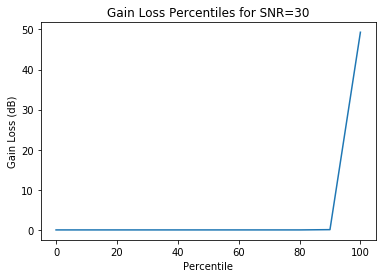

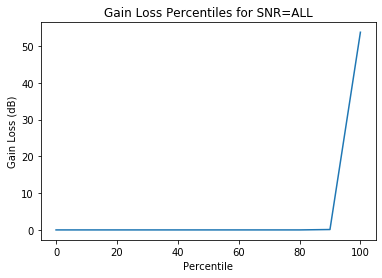

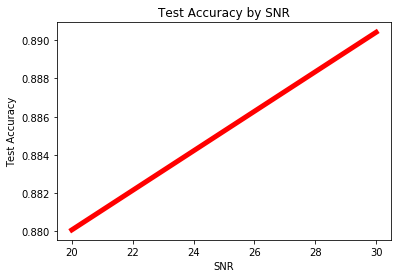

In [28]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 596us/sample - loss: 1.8900 - sparse_categorical_accuracy: 0.5598
Epoch 2/75
2040/2040 [==============================] - 1s 278us/sample - loss: 0.8743 - sparse_categorical_accuracy: 0.7912
Epoch 3/75
2040/2040 [==============================] - 1s 279us/sample - loss: 0.6211 - sparse_categorical_accuracy: 0.8338
Epoch 4/75
2040/2040 [==============================] - 1s 278us/sample - loss: 0.5553 - sparse_categorical_accuracy: 0.8348
Epoch 5/75
2040/2040 [==============================] - 1s 278us/sample - loss: 0.4747 - sparse_categorical_accuracy: 0.8578
Epoch 6/75
2040/2040 [==============================] - 1s 272us/sample - loss: 0.4455 - sparse_categorical_accuracy: 0.8534
Epoch 7/75
2040/2040 [==============================] - 1s 277us/sample - loss: 0.4219 - sparse_categorical_accuracy: 0.8652
Epoch 8/75
2040/2040 [==============================] - 1s 274us/samp

Text(0.5, 0, 'Epoch')

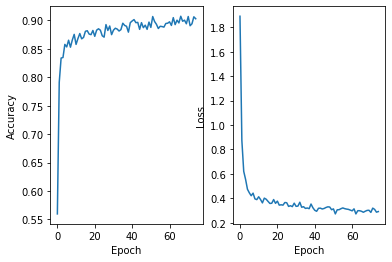

In [31]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.4761 - sparse_categorical_accuracy: 0.8670
	Test accuracy: 0.86703783


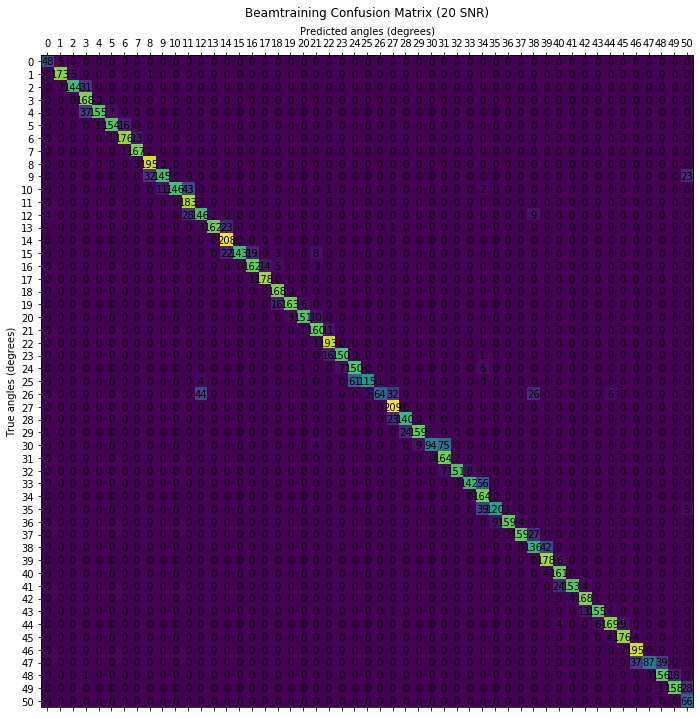

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.4028 - sparse_categorical_accuracy: 0.8870
	Test accuracy: 0.88697106


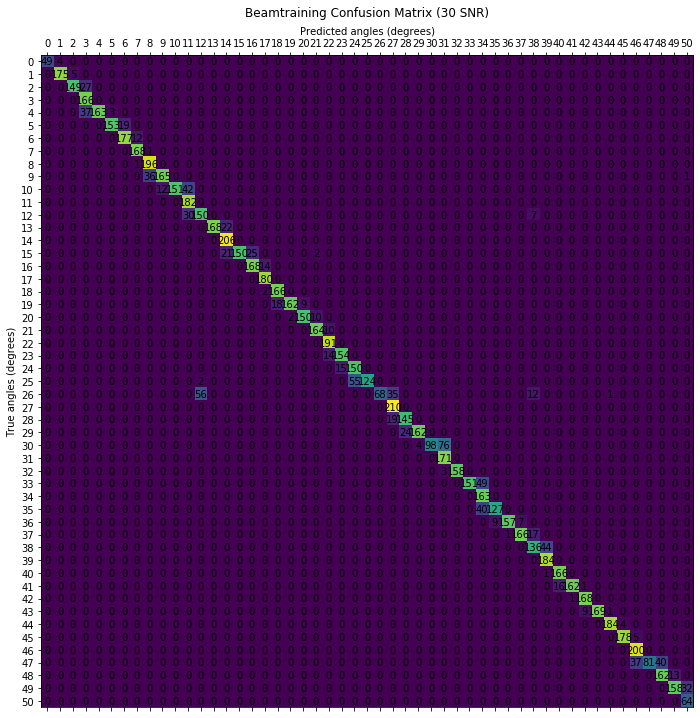

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.4394 - sparse_categorical_accuracy: 0.8770
	Test accuracy: 0.87700444


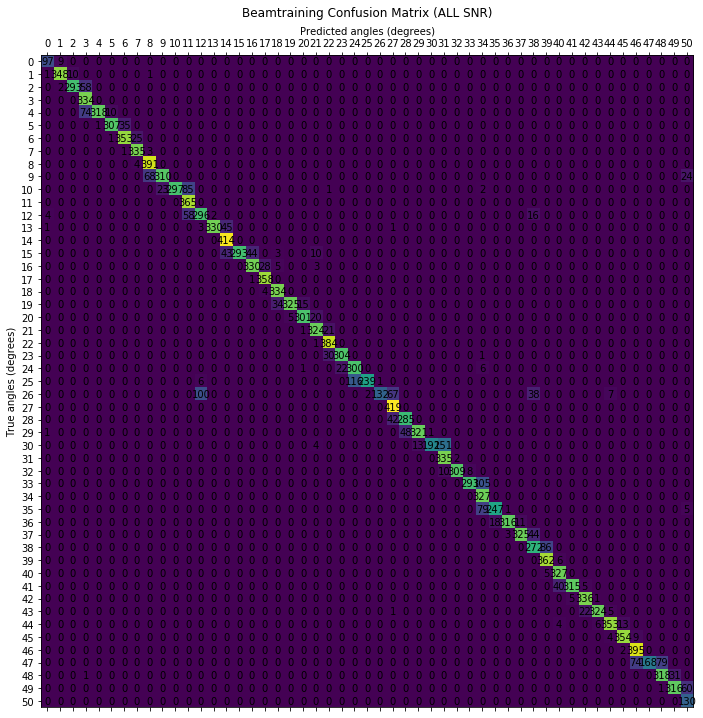


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.222]
 [100.     48.946]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 9.3000e-02]
 [1.0000e+02 3.9556e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.16 ]
 [100.     48.946]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.86703783273

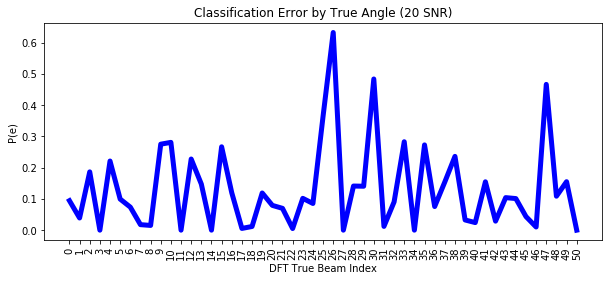

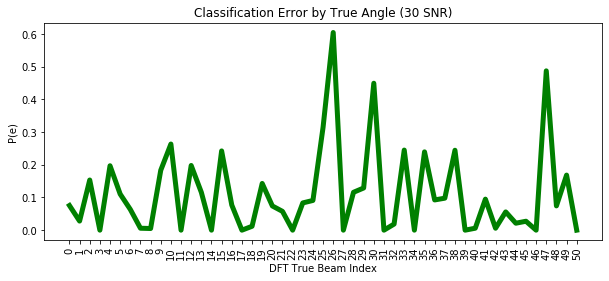

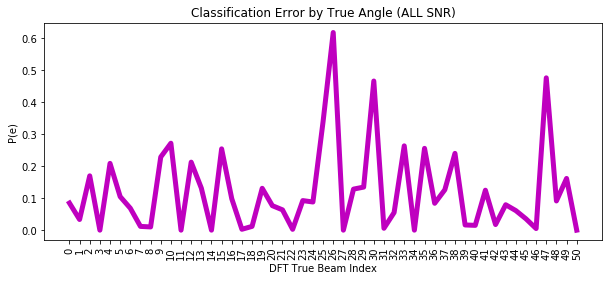

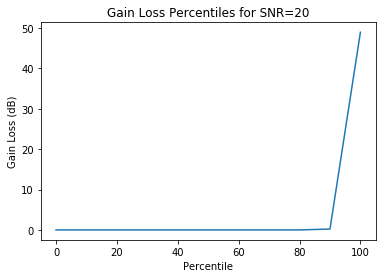

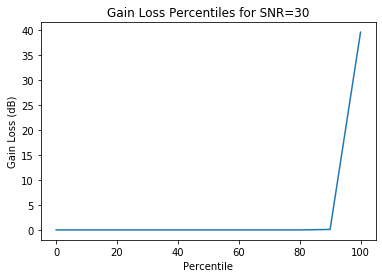

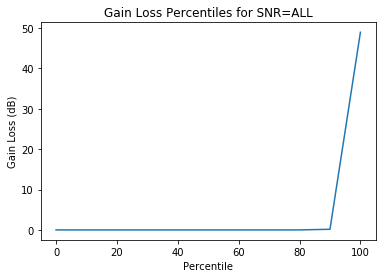

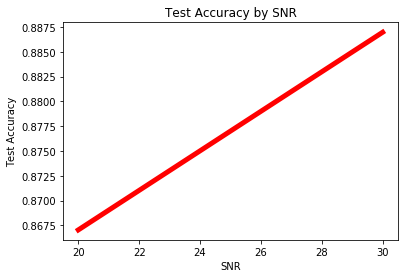

In [32]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
batch_normalization_14 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 16,179
Trainable params: 15,795
Non-trainable params: 384
___________________

Text(0.5, 0, 'Epoch')

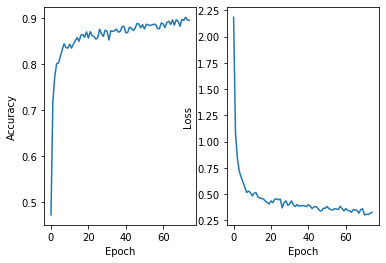

In [35]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3500 - sparse_categorical_accuracy: 0.8921
	Test accuracy: 0.89209354


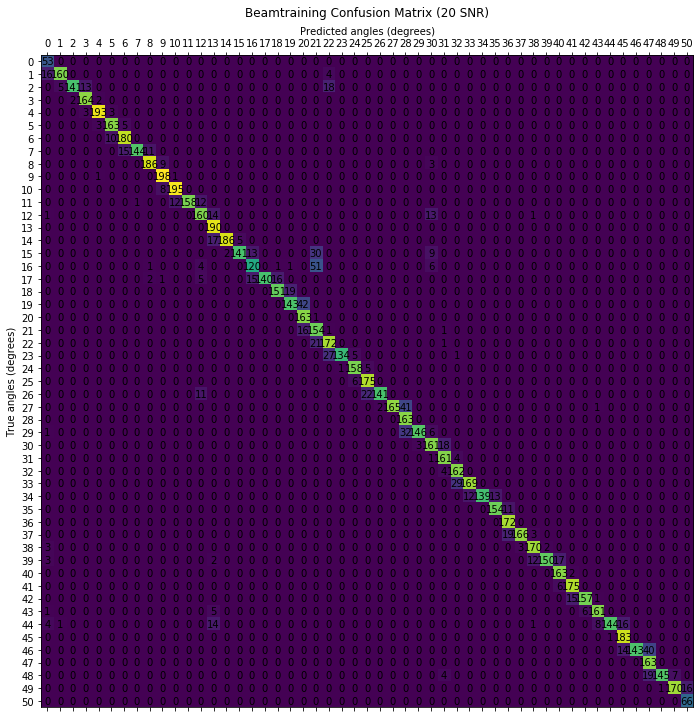

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2636 - sparse_categorical_accuracy: 0.9065
	Test accuracy: 0.9064588


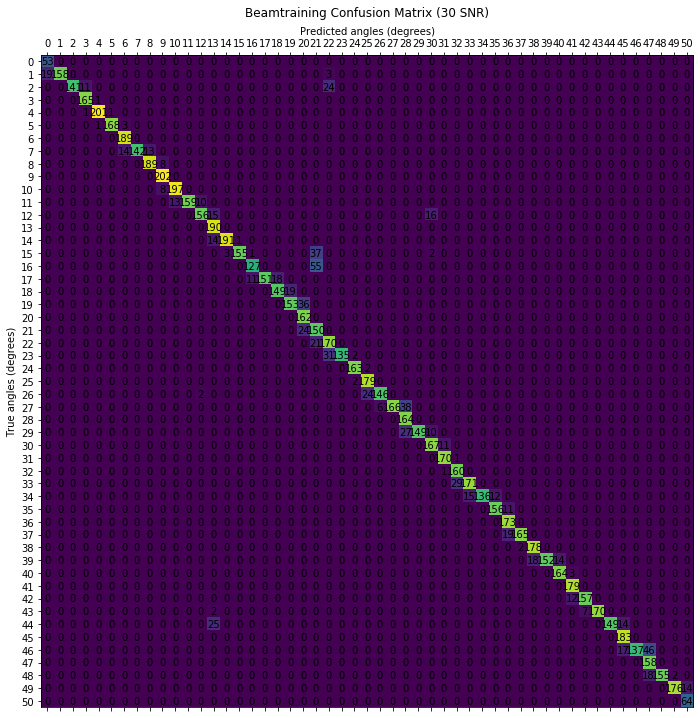

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.3068 - sparse_categorical_accuracy: 0.8993
	Test accuracy: 0.8992762


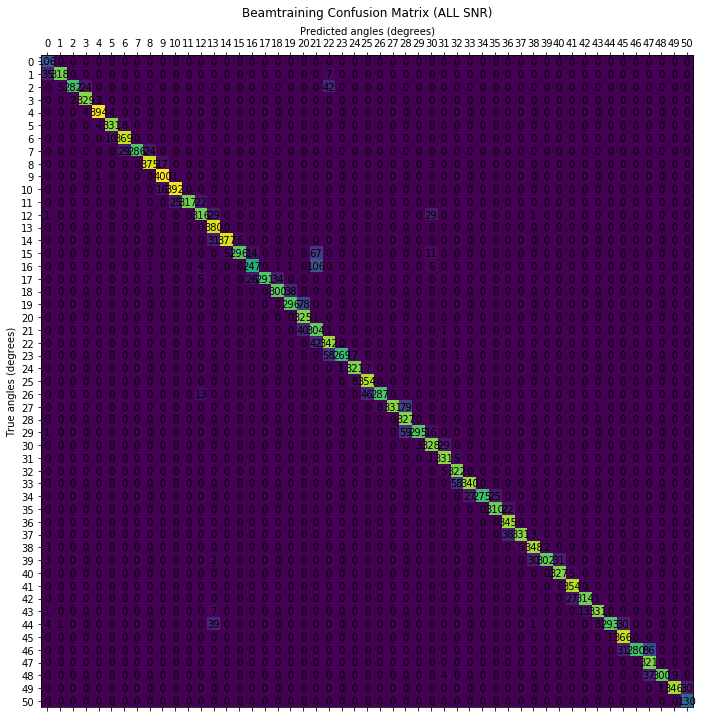


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 5.2000e-02]
 [1.0000e+02 6.3621e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     73.608]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 4.0000e-03]
 [1.0000e+02 7.3608e

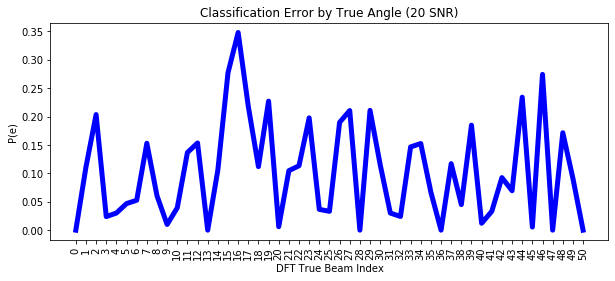

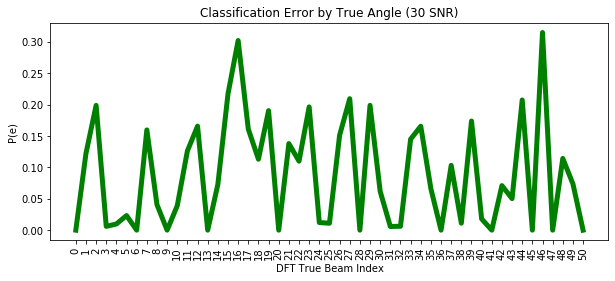

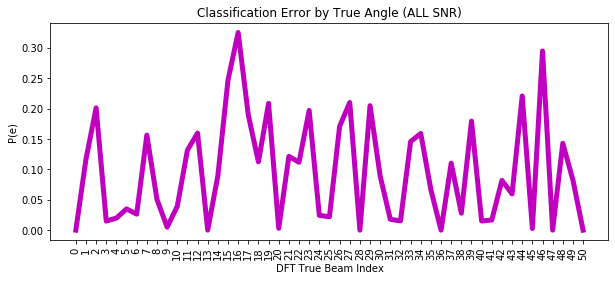

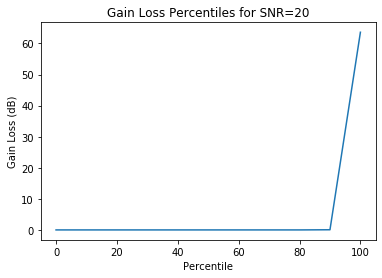

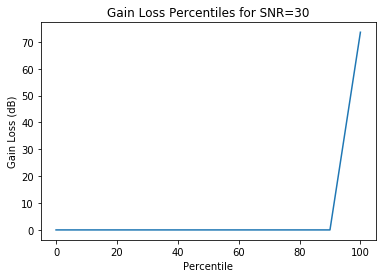

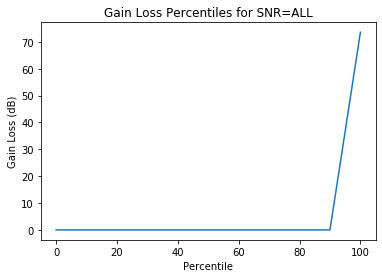

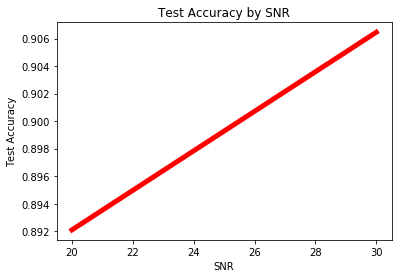

In [36]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 677us/sample - loss: 2.3159 - sparse_categorical_accuracy: 0.4069
Epoch 2/75
2040/2040 [==============================] - 1s 371us/sample - loss: 1.4472 - sparse_categorical_accuracy: 0.6088
Epoch 3/75
2040/2040 [==============================] - 1s 379us/sample - loss: 1.2860 - sparse_categorical_accuracy: 0.6412
Epoch 4/75
2040/2040 [==============================] - 1s 385us/sample - loss: 1.1293 - sparse_categorical_accuracy: 0.6770
Epoch 5/75
2040/2040 [==============================] - 1s 369us/sample - loss: 1.0171 - sparse_categorical_accuracy: 0.7015
Epoch 6/75
2040/2040 [==============================] - 1s 371us/sample - loss: 1.0169 - sparse_categorical_accuracy: 0.6941
Epoch 7/75
2040/2040 [==============================] - 1s 369us/sample - loss: 0.9439 - sparse_categorical_accuracy: 0.7260
Epoch 8/75
2040/2040 [==============================] - 1s 369us/samp

Text(0.5, 0, 'Epoch')

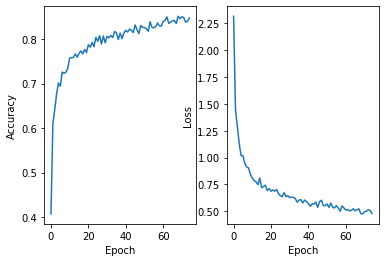

In [41]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.6785 - sparse_categorical_accuracy: 0.8115
	Test accuracy: 0.8114699


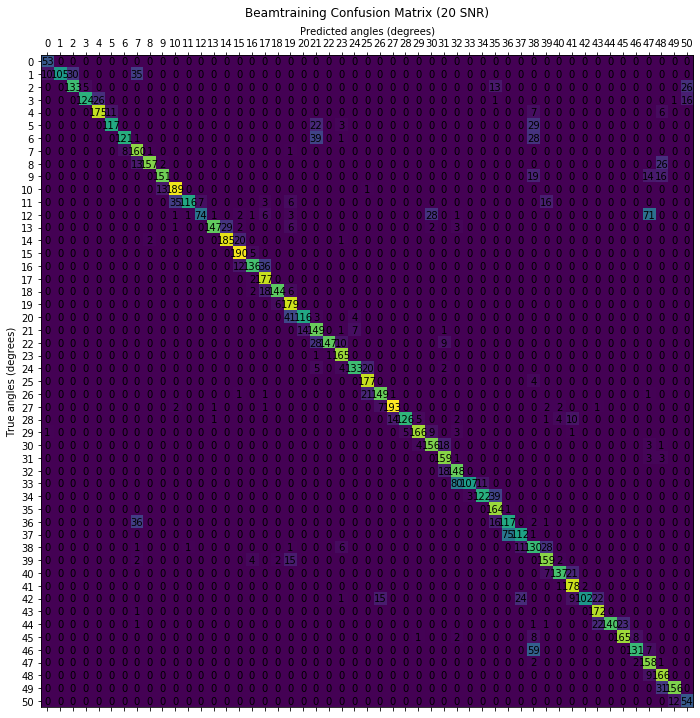

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.4871 - sparse_categorical_accuracy: 0.8559
	Test accuracy: 0.855902


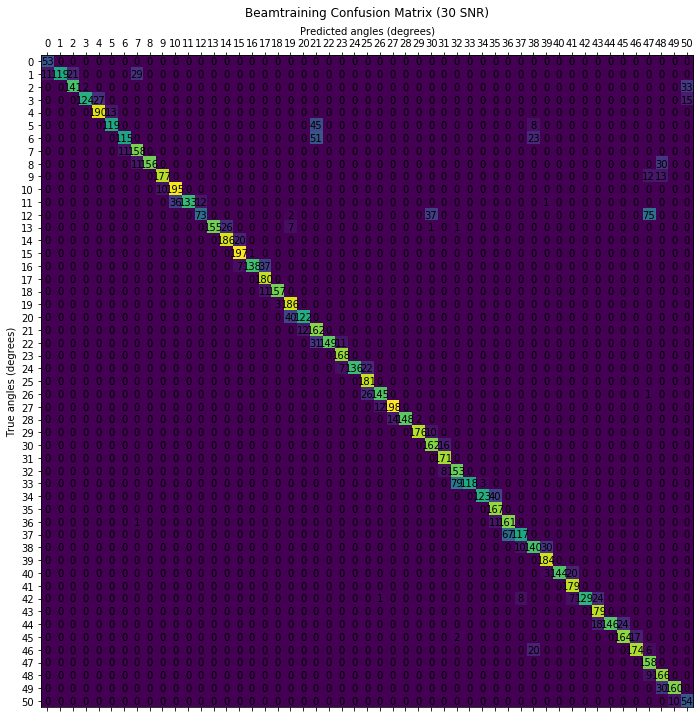

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.5828 - sparse_categorical_accuracy: 0.8337
	Test accuracy: 0.833686


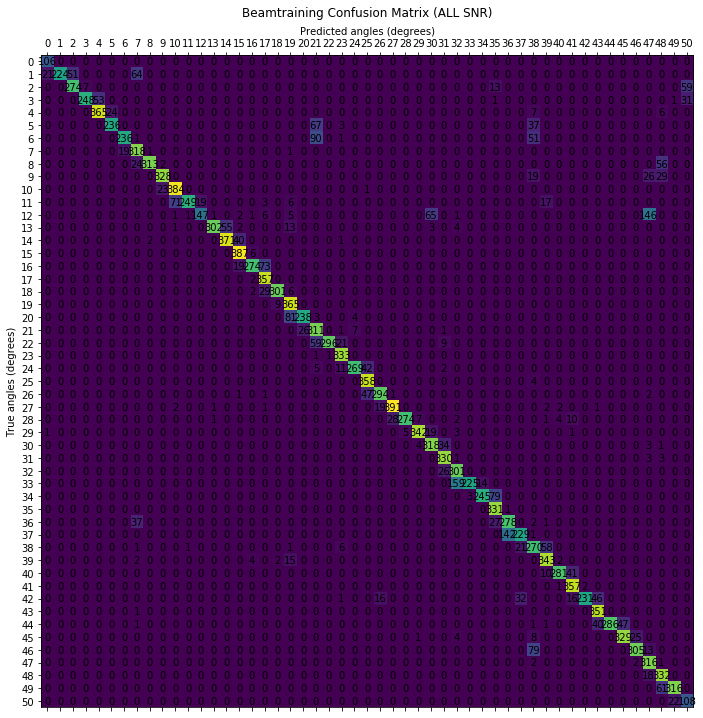


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      1.123]
 [100.     54.63 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.371]
 [100.     58.234]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.668]
 [100.     58.234]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8114699125289917
	SNR: 30; Accuracy: 0.8559020161628723


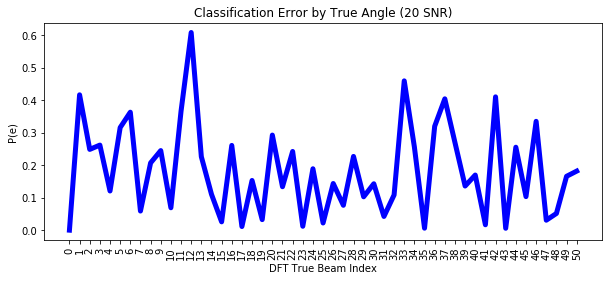

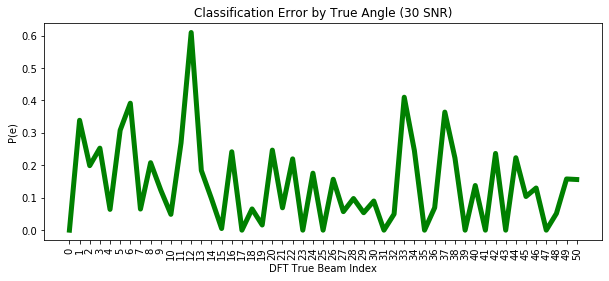

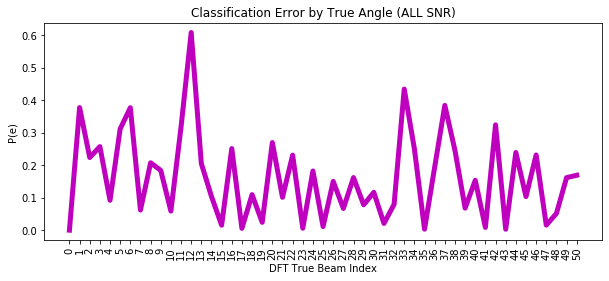

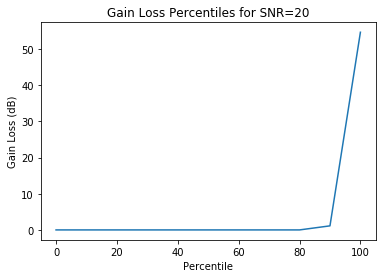

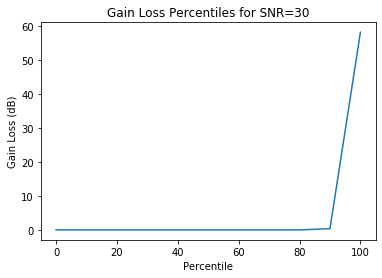

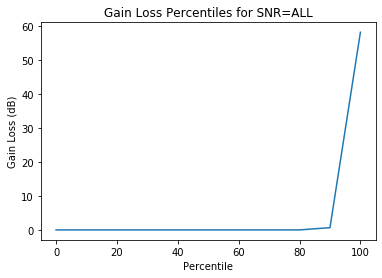

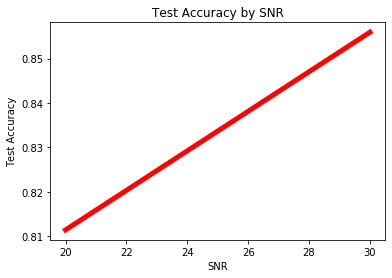

In [42]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 5 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 2s 768us/sample - loss: 2.5833 - sparse_categorical_accuracy: 0.3176
Epoch 2/75
2040/2040 [==============================] - 1s 466us/sample - loss: 1.8830 - sparse_categorical_accuracy: 0.4770
Epoch 3/75
2040/2040 [==============================] - 1s 466us/sample - loss: 1.6791 - sparse_categorical_accuracy: 0.5201
Epoch 4/75
2040/2040 [==============================] - 1s 475us/sample - loss: 1.4496 - sparse_categorical_accuracy: 0.5902
Epoch 5/75
2040/2040 [==============================] - 1s 458us/sample - loss: 1.2851 - sparse_categorical_accuracy: 0.6289
Epoch 6/75
2040/2040 [==============================] - 1s 455us/sample - loss: 1.1399 - sparse_categorical_accuracy: 0.6716
Epoch 7/75
2040/2040 [==============================] - 1s 458us/sample - loss: 1.1108 - sparse_categorical_accuracy: 0.6721
Epoch 8/75
2040/2040 [==============================] - 1s 447us/samp

Text(0.5, 0, 'Epoch')

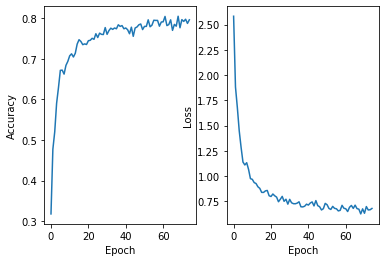

In [78]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.8398 - sparse_categorical_accuracy: 0.7981
	Test accuracy: 0.7981069


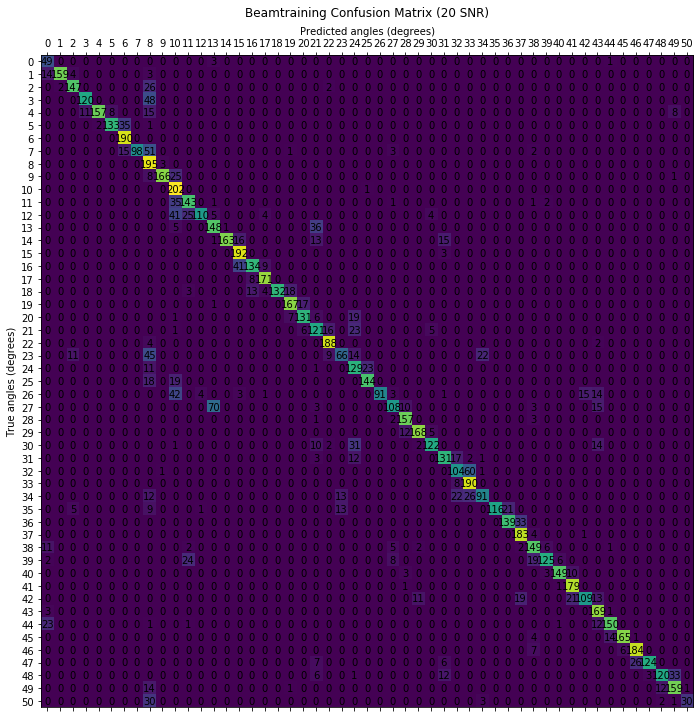

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.5774 - sparse_categorical_accuracy: 0.8496
	Test accuracy: 0.84955454


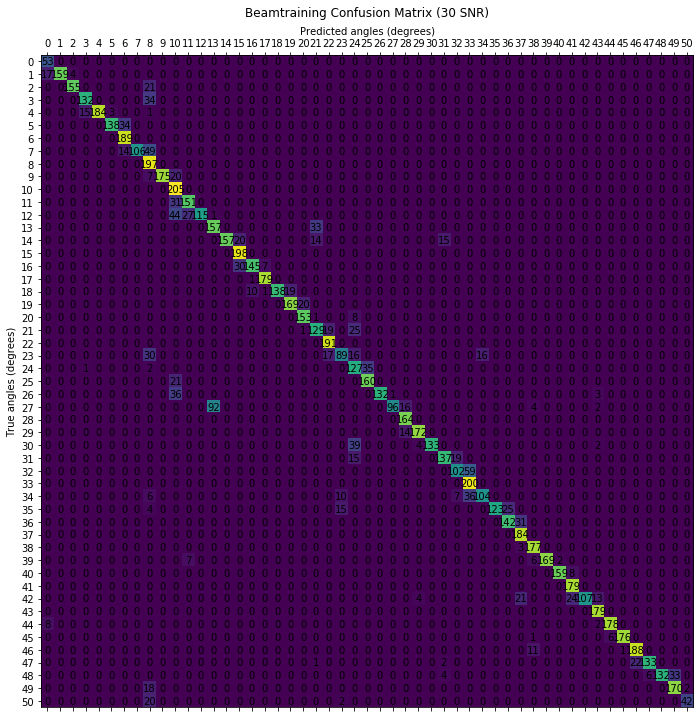

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.7086 - sparse_categorical_accuracy: 0.8238
	Test accuracy: 0.8238307


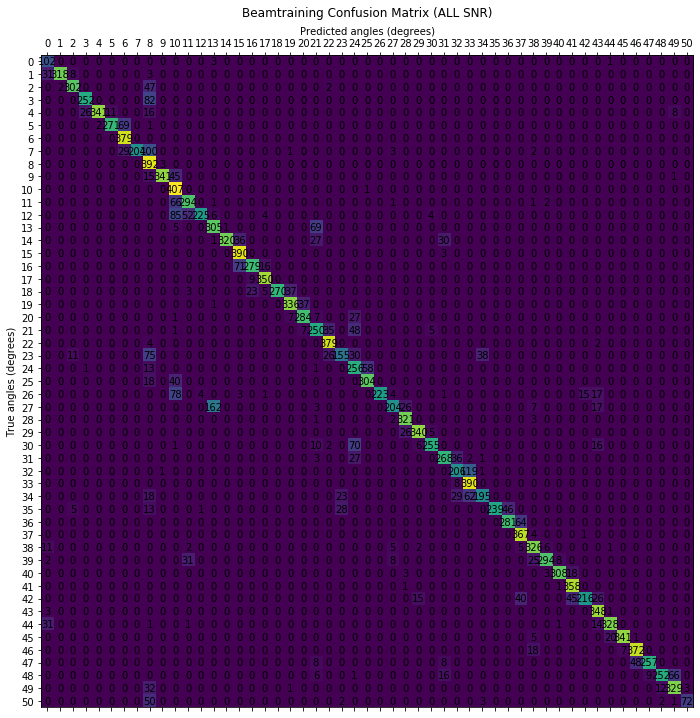


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 1.7000e-02]
 [9.0000e+01 1.6763e+01]
 [1.0000e+02 5.8891e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.54 ]
 [100.     71.189]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      1.303]
 [100.     71.189]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.79810690879

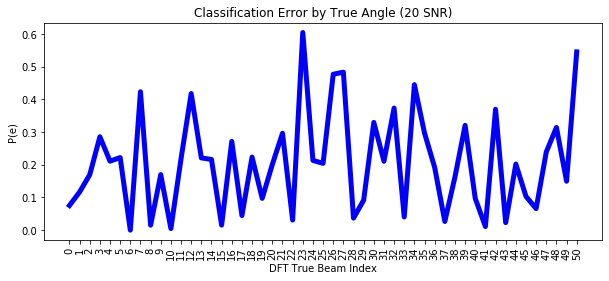

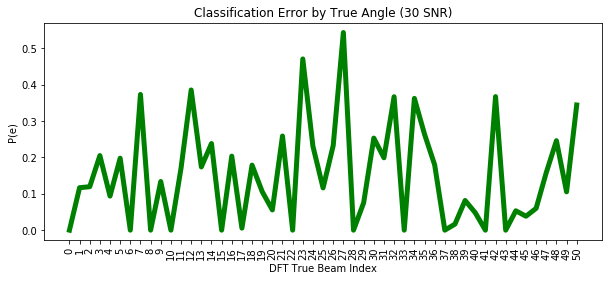

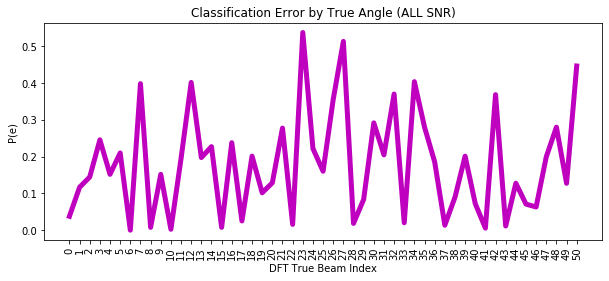

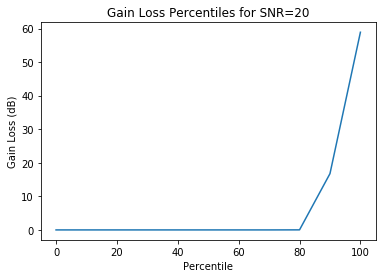

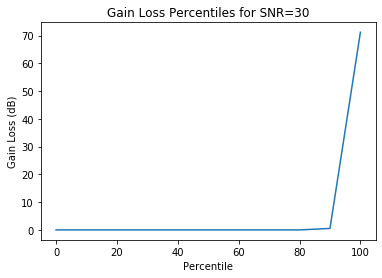

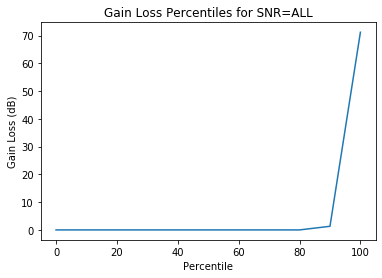

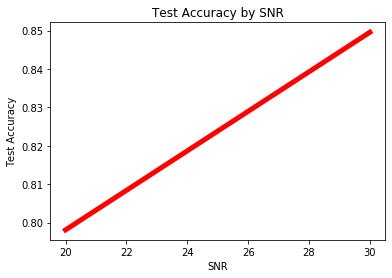

In [79]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 4 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 2s 901us/sample - loss: 2.9698 - sparse_categorical_accuracy: 0.2152
Epoch 2/75
2040/2040 [==============================] - 1s 569us/sample - loss: 2.5101 - sparse_categorical_accuracy: 0.3147
Epoch 3/75
2040/2040 [==============================] - 1s 561us/sample - loss: 2.4082 - sparse_categorical_accuracy: 0.3304
Epoch 4/75
2040/2040 [==============================] - 1s 555us/sample - loss: 2.2944 - sparse_categorical_accuracy: 0.3618
Epoch 5/75
2040/2040 [==============================] - 1s 562us/sample - loss: 2.1156 - sparse_categorical_accuracy: 0.4025
Epoch 6/75
2040/2040 [==============================] - 1s 523us/sample - loss: 2.0299 - sparse_categorical_accuracy: 0.4260
Epoch 7/75
2040/2040 [==============================] - 1s 529us/sample - loss: 1.9485 - sparse_categorical_accuracy: 0.4554
Epoch 8/75
2040/2040 [==============================] - 1s 532us/samp

Text(0.5, 0, 'Epoch')

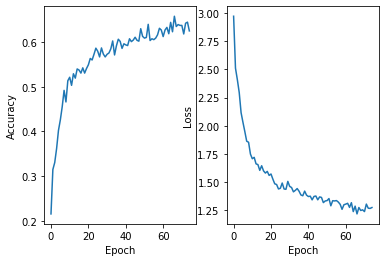

In [51]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 1.8644 - sparse_categorical_accuracy: 0.6467
	Test accuracy: 0.64665926


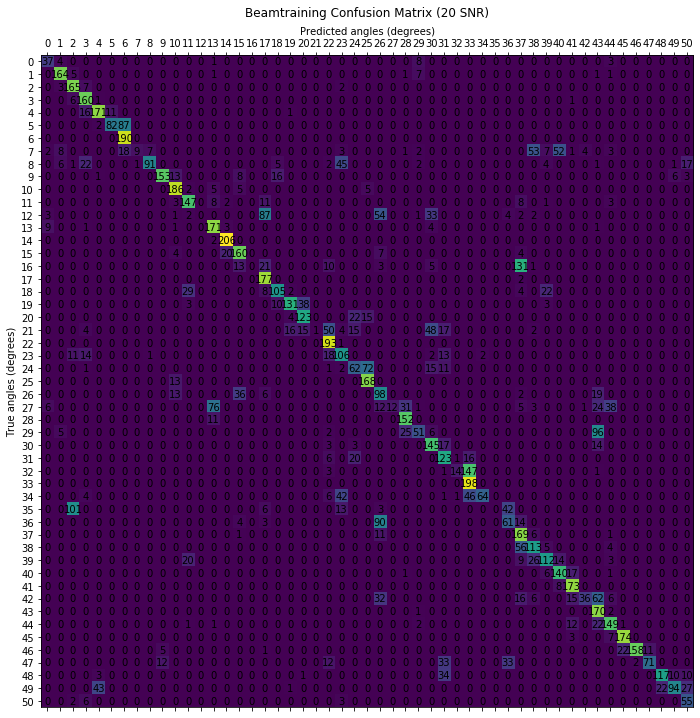

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 1.5531 - sparse_categorical_accuracy: 0.7077
	Test accuracy: 0.70768374


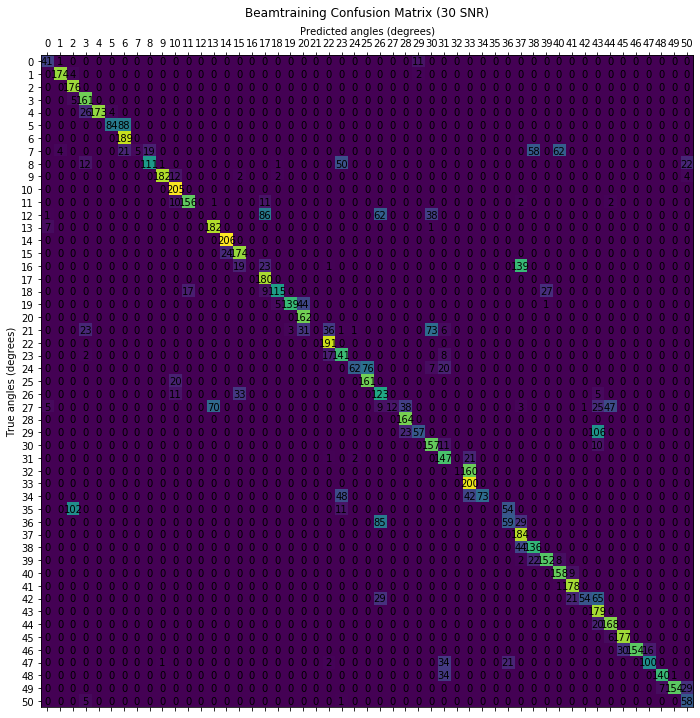

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 1.7087 - sparse_categorical_accuracy: 0.6772
	Test accuracy: 0.67717147


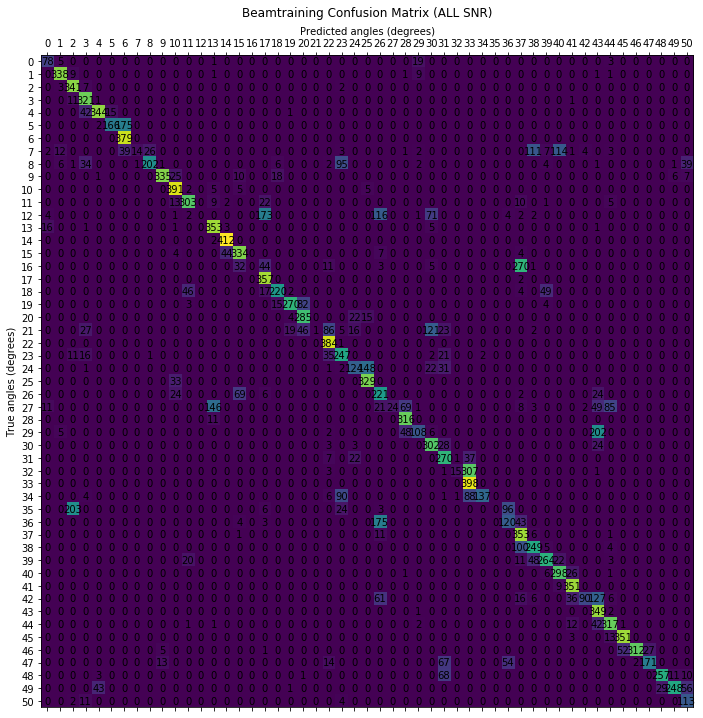


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.604 ]
 [ 80.      19.6274]
 [ 90.      29.464 ]
 [100.      61.294 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      1.459]
 [ 90.     28.165]
 [100.     71.189]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.192 ]
 [ 80.       6.2122]
 [ 90.      28.949 ]
 [100.      71.189 ]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.646659255027771
	SNR: 30; Accurac

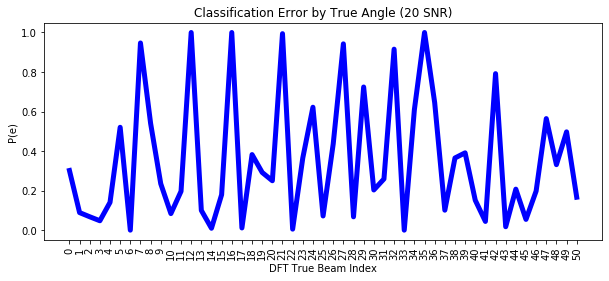

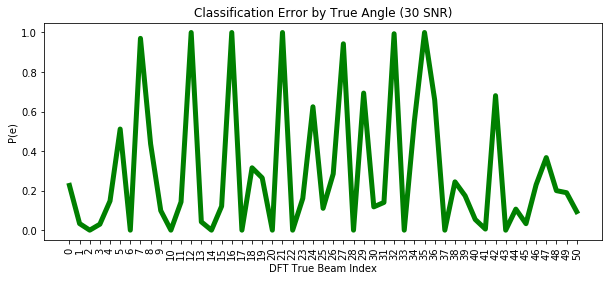

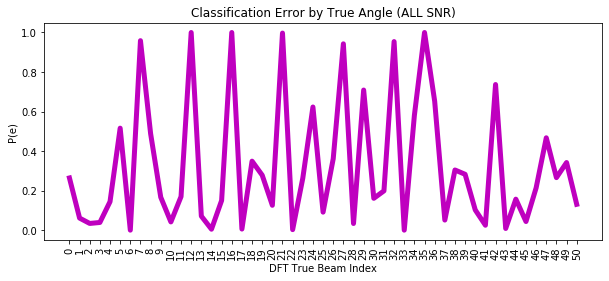

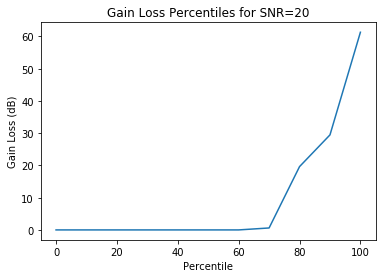

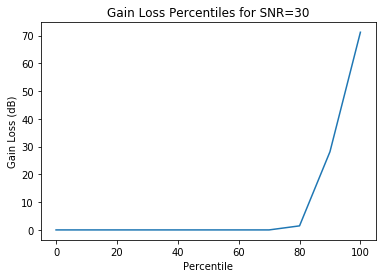

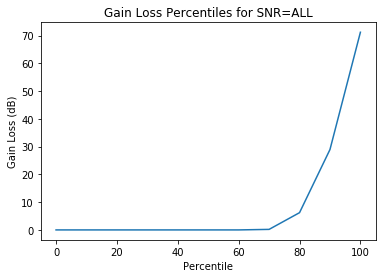

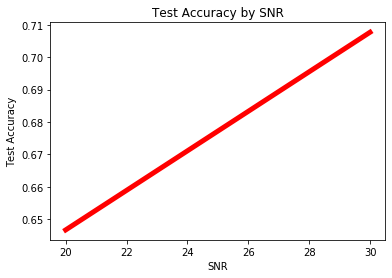

In [52]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 3 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.3969 - sparse_categorical_accuracy: 0.1216
Epoch 2/75
2040/2040 [==============================] - 2s 774us/sample - loss: 3.1409 - sparse_categorical_accuracy: 0.1775
Epoch 3/75
2040/2040 [==============================] - 2s 781us/sample - loss: 2.9899 - sparse_categorical_accuracy: 0.2167
Epoch 4/75
2040/2040 [==============================] - 2s 761us/sample - loss: 2.8836 - sparse_categorical_accuracy: 0.2343
Epoch 5/75
2040/2040 [==============================] - 2s 769us/sample - loss: 2.8103 - sparse_categorical_accuracy: 0.2451
Epoch 6/75
2040/2040 [==============================] - 2s 763us/sample - loss: 2.7498 - sparse_categorical_accuracy: 0.2662
Epoch 7/75
2040/2040 [==============================] - 2s 761us/sample - loss: 2.7307 - sparse_categorical_accuracy: 0.2681
Epoch 8/75
2040/2040 [==============================] - 2s 787us/sample

Text(0.5, 0, 'Epoch')

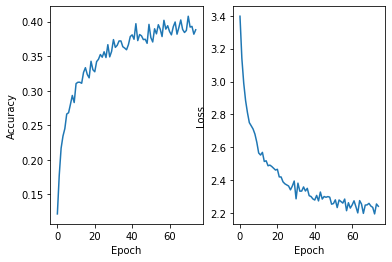

In [55]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 49)
8980/8980 - 0s - loss: 3.2509 - sparse_categorical_accuracy: 0.4122
	Test accuracy: 0.41224945


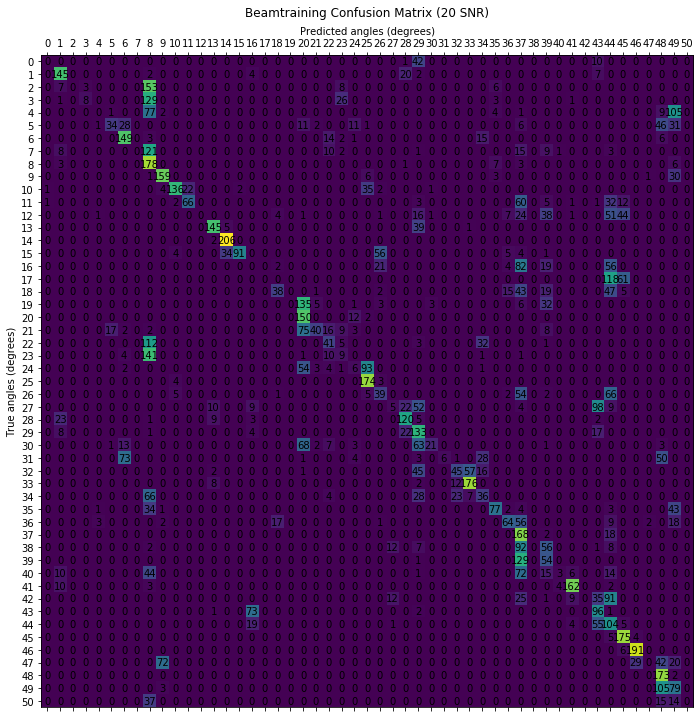

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (1, 49)
8980/8980 - 0s - loss: 2.8301 - sparse_categorical_accuracy: 0.4425
	Test accuracy: 0.44253898


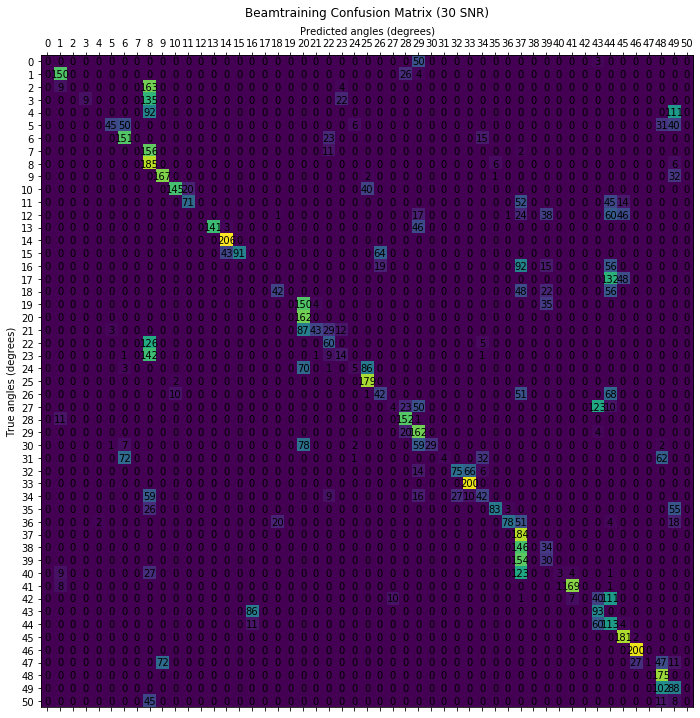

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 49)
17960/17960 - 1s - loss: 3.0405 - sparse_categorical_accuracy: 0.4274
	Test accuracy: 0.4273942


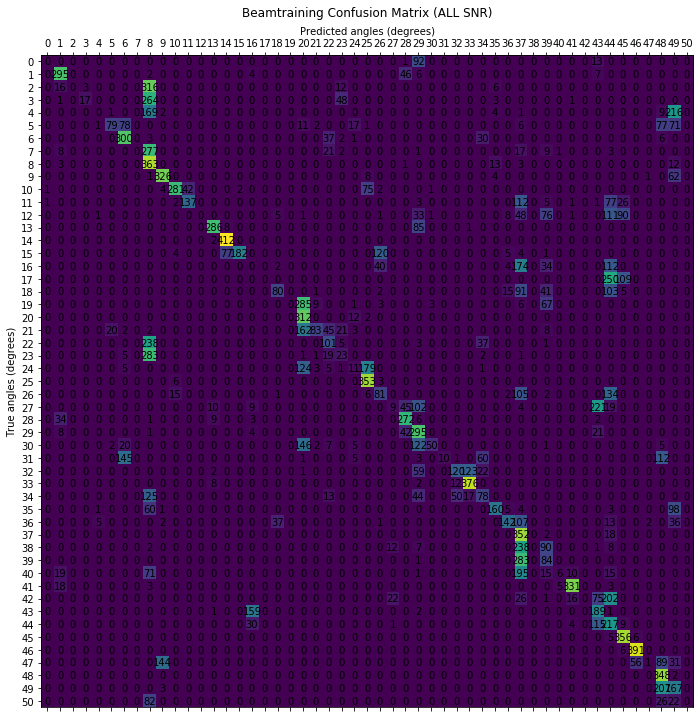


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       2.023 ]
 [ 60.      16.9656]
 [ 70.      26.495 ]
 [ 80.      30.626 ]
 [ 90.      35.168 ]
 [100.      58.706 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.869 ]
 [ 60.      10.4417]
 [ 70.      26.11  ]
 [ 80.      31.037 ]
 [ 90.      37.713 ]
 [100.      67.95  ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       1.288 ]
 [ 60.      13.9214]
 [ 70.      26.308 ]
 [ 80.      30.799 ]
 [ 90.      36.186 ]
 [100.      67.95  ]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.41224944591

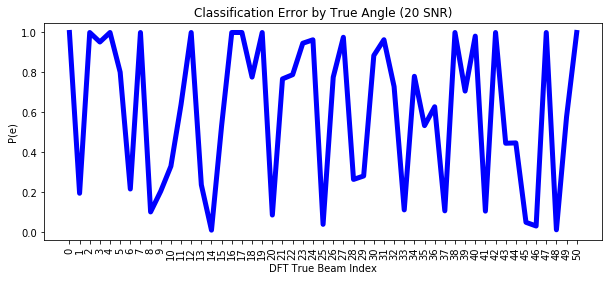

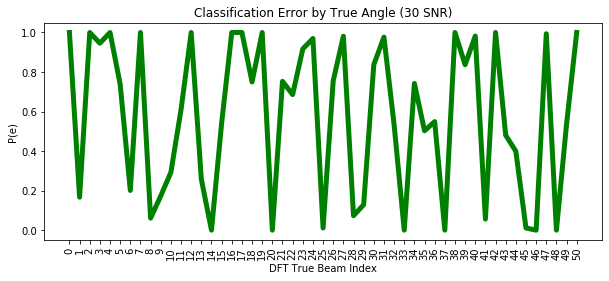

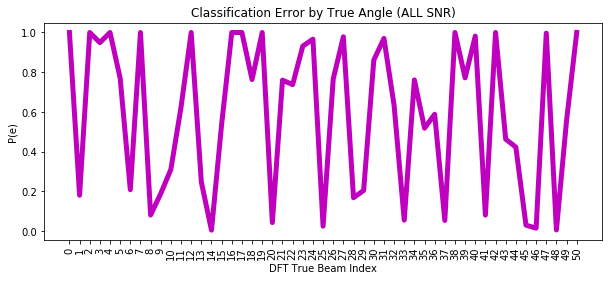

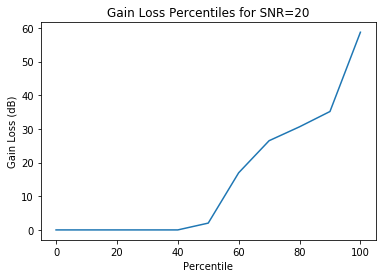

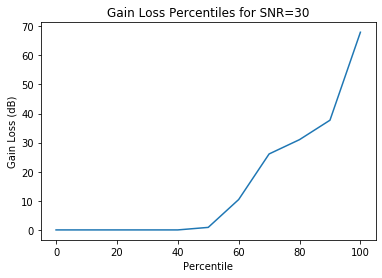

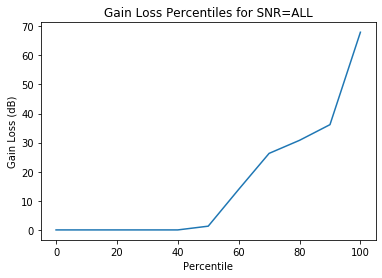

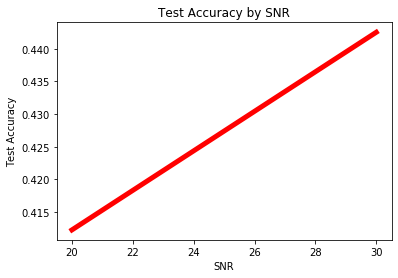

In [56]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 2 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 3s 1ms/sample - loss: 3.7466 - sparse_categorical_accuracy: 0.0515
Epoch 2/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6987 - sparse_categorical_accuracy: 0.0662
Epoch 3/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6956 - sparse_categorical_accuracy: 0.0706
Epoch 4/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6672 - sparse_categorical_accuracy: 0.0701
Epoch 5/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6567 - sparse_categorical_accuracy: 0.0784
Epoch 6/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6405 - sparse_categorical_accuracy: 0.0843
Epoch 7/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6471 - sparse_categorical_accuracy: 0.0892
Epoch 8/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.611

Text(0.5, 0, 'Epoch')

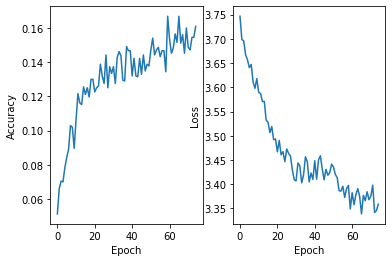

In [59]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (2, 44)
8980/8980 - 0s - loss: 14.2584 - sparse_categorical_accuracy: 0.1007
	Test accuracy: 0.100668155


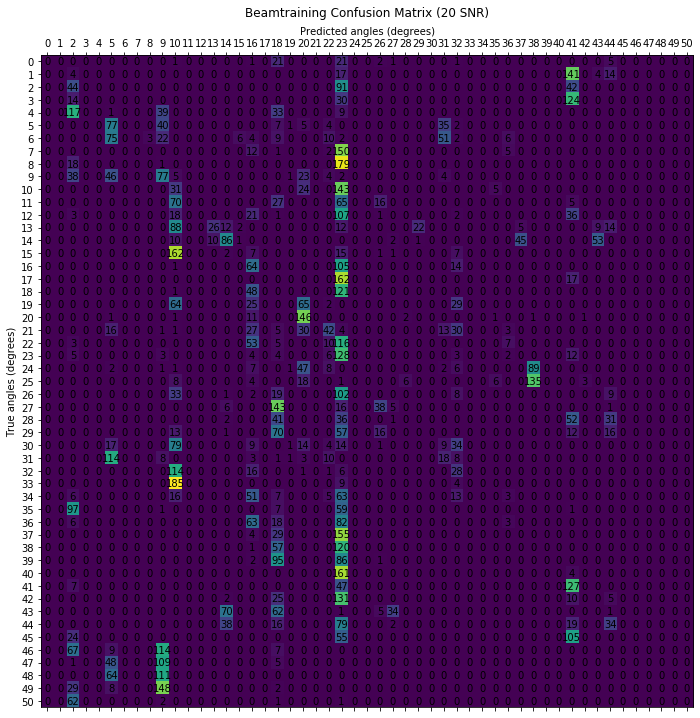

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (2, 44)
8980/8980 - 0s - loss: 14.1803 - sparse_categorical_accuracy: 0.1084
	Test accuracy: 0.10835189


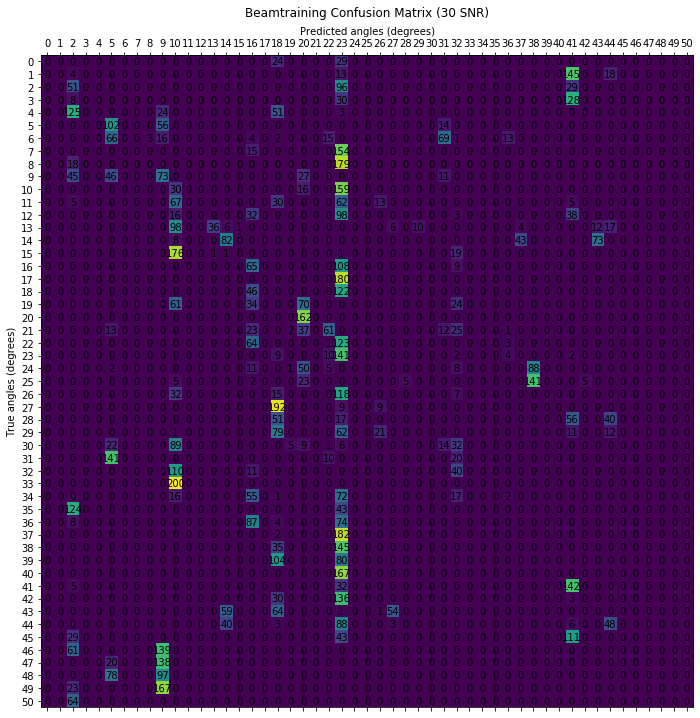

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (2, 44)
17960/17960 - 1s - loss: 14.2194 - sparse_categorical_accuracy: 0.1045
	Test accuracy: 0.104510024


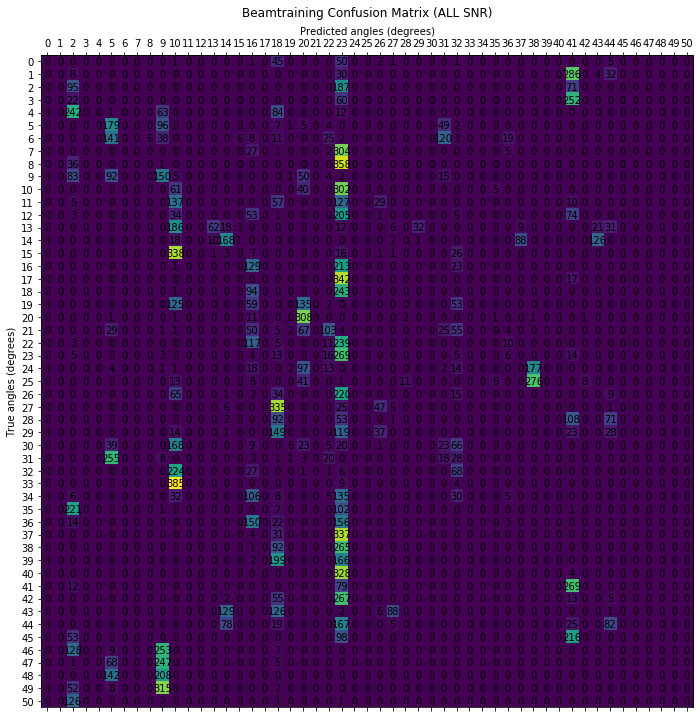


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.      14.317 ]
 [ 30.      21.8205]
 [ 40.      25.2269]
 [ 50.      27.397 ]
 [ 60.      29.347 ]
 [ 70.      31.305 ]
 [ 80.      33.659 ]
 [ 90.      37.011 ]
 [100.      72.041 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.      14.1482]
 [ 30.      22.2171]
 [ 40.      25.54  ]
 [ 50.      28.066 ]
 [ 60.      30.212 ]
 [ 70.      32.093 ]
 [ 80.      34.483 ]
 [ 90.      39.294 ]
 [100.      71.05  ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.        0.     ]
 [ 10.        0.     ]
 [ 20.       14.23947]
 [ 30.       21.9707 ]
 [ 40.       25.386  ]
 [ 50.       27.688  ]
 [ 60.       29.777  ]
 [ 70.       31.679  ]
 [ 80.       34.009  ]
 [ 90.       38.013  ]
 [100.       72.041  ]]

Average Test Accuracies: 
	SNR: 20; A

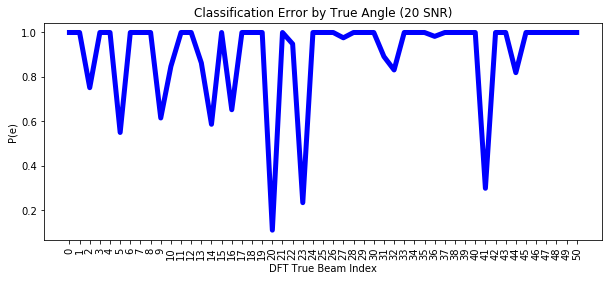

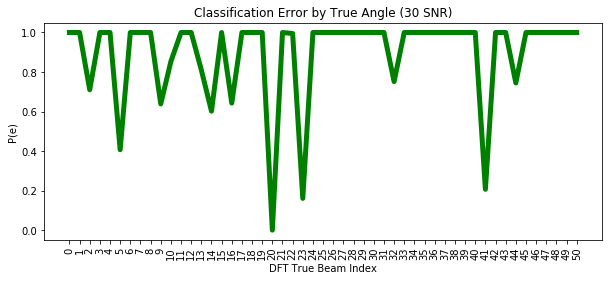

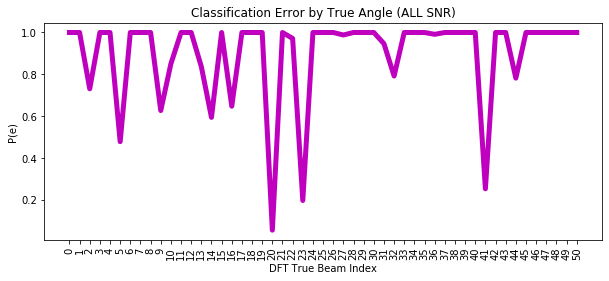

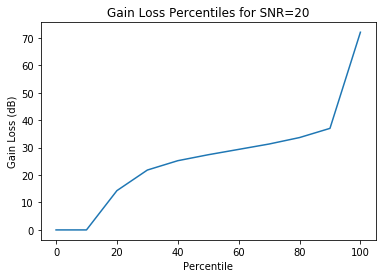

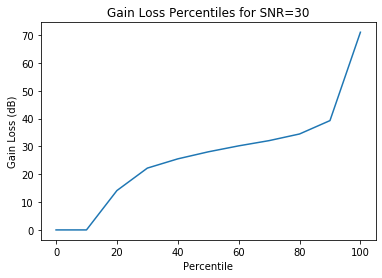

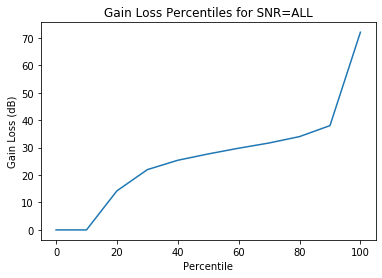

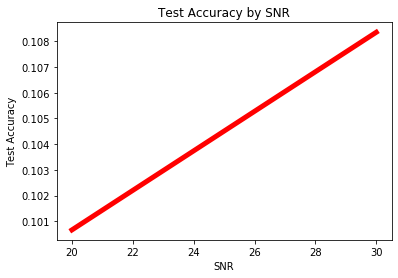

In [60]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Overall Results Plots

In [80]:
# Check that all M values were tested
print(len(all_gainLoss))
print(all_gainLoss.keys())
#print(all_gainLoss[2][2,0,:])
#print(len(GAIN_LOSS_PERCENTILES))

14
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2, 16])


In [83]:
## Save total results to a pickle file
import pickle

## See how many results are available
print(len(all_test_acc))
print(len(all_confusionMat))
print(len(all_pe_byLabel))
print(len(all_gainLoss))

print(all_test_acc.keys())
print(all_test_acc[2])

## Save to a pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS SAVED
#TODO: SAVE ALL GAIN LOSS PERCENTILES AND MODELS TO AN OVERALL DICTIONARY
with open('all_NN_sim4_results.pkl', 'wb') as f:
    pickle.dump([all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss], f)
    #TODO: ADD MORE VARS

14
14
14
14
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2, 16])
[[0.10066815 0.10835189 0.10451002]]


In [ ]:
## Load the pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS CAPTURED
with open('all_NN_sim2_results.pkl', 'rb') as f:
    all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss = pickle.load(f)

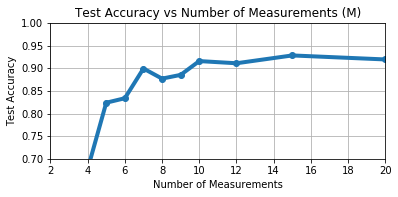

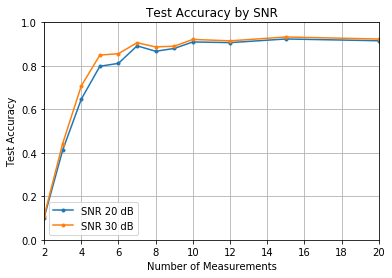

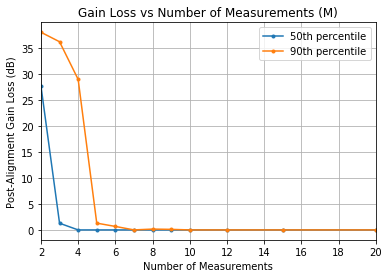

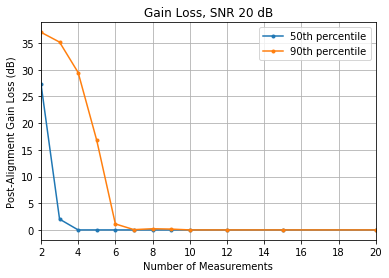

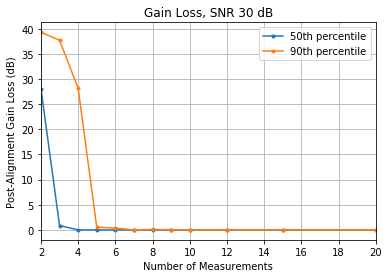

In [85]:
### Plot the overall results for the testing with all SNRs
included_num_meas = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20])
plot_test_acc_allsnr = np.zeros((len(DATA_SNR)+1, len(included_num_meas)))

# Averaged over all PN beam combos
for m_i in np.arange(len(included_num_meas)):
    for snr_ind in np.arange(len(DATA_SNR)+1):
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
        else:
            SNR_i = 'ALL'
        temp_test_acc = all_test_acc[included_num_meas[m_i]]
        plot_test_acc_allsnr[snr_ind, m_i] = np.mean(temp_test_acc[:, snr_ind])

# Plot the result
# Plot of accuracy testing all SNRs together
fig = plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[len(DATA_SNR), :], marker="o", lw=4)
plt.title("Test Accuracy vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0.7, 1)
plt.yticks(np.arange(70, 105, 5)/100)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
fig.set_size_inches(6, 2.5)
plt.savefig("../figures/nn_acc_allSNR_sim4.png")

# Plot of accuracy vs each SNR
plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[np.arange(len(DATA_SNR)), :].T, marker=".")
plt.title("Test Accuracy by SNR")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.legend(("SNR {} dB".format(DATA_SNR[0]), "SNR {} dB".format(DATA_SNR[1])))
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))

# Extract all the gain loss statistics
percentile_indices = np.array([5, 9]) # indices correspond to 0:10:100 (i.e. 5 -> 50%)
plot_all_gainLoss = np.zeros((len(included_num_meas), len(DATA_SNR)+1, len(GAIN_LOSS_PERCENTILES)))
for snr_ind in np.arange(len(DATA_SNR)+1):
    for m_i in np.arange(len(included_num_meas)):
        plot_all_gainLoss[m_i, snr_ind, :] = all_gainLoss[included_num_meas[m_i]][snr_ind, 0, :]

# Plot of 50th and 90th percentile gain loss testing all SNRs together
plt.figure()
plt.plot(included_num_meas, plot_all_gainLoss[:, len(DATA_SNR), percentile_indices], marker=".")
plt.title("Gain Loss vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Post-Alignment Gain Loss (dB)")
plt.grid(True)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
#fig.set_size_inches(6, 2.5)
plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
plt.savefig("../figures/nn_gainLoss_allSNR_sim4.png")

# Plot of gain loss vs each SNR
for plot_snr_ind in np.arange(len(DATA_SNR)):
    plt.figure()
    plt.plot(included_num_meas, plot_all_gainLoss[:, plot_snr_ind, percentile_indices], marker=".")
    plt.title("Gain Loss, SNR {} dB".format(DATA_SNR[plot_snr_ind]))
    plt.xlabel("Number of Measurements")
    plt.ylabel("Post-Alignment Gain Loss (dB)")
    plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
    plt.grid(True)
    plt.xlim(np.min(included_num_meas),np.max(included_num_meas))


# Regression Method - Continuous Angle Prediction
For data communication, a true angle prediction might be better than a discrete classification.  Classification heavily penalizes wrongly classifying to neighboring beams, even if the angle is almost exactly in between the two beam angles.  This may not be realistic for real-world implementations, as the actual beam may have significantly more angular control and thus could steer to the exact direction between the training beams.  Even without the ability to steer in any direction, classifying to neighboring beams should intuitively be better than classifying to further beams.

In [41]:
### Variable reorganization for regression (add another dimension) ###

# ALL DATA/LABEL/ANGLE VARIABLES FOR REGRESSION ARE LABELED AS "*_r" (where * is the original name used for classification)
USING_CNN_ARG = False

## Storage dictionaries/running variables for regression
train_data_dict_r = {}
test_data_dict_r = {}
val_data_dict_r = {}
train_angles_dict_r = {}
test_angles_dict_r = {}
val_angles_dict_r = {}
train_labels_dict_r = {}
test_labels_dict_r = {}
val_labels_dict_r = {}

# For the regression method with CNNs, need dimensions to be N x D x 1 (instead of N x D or D x N)
print("Modifying training/validation/testing datasets:")
for snr_i in np.arange(len(train_data_dict)):
    if USING_CNN_ARG:
        train_data_dict_r[SNR[snr_i]] = np.array([train_data_dict[SNR[snr_i]].T]).T
        train_labels_dict_r[SNR[snr_i]] = np.array([train_labels_dict[SNR[snr_i]].T]).T
        train_angles_dict_r[SNR[snr_i]] = np.array([train_angles_dict[SNR[snr_i]].T]).T

        val_data_dict_r[SNR[snr_i]] = np.array([val_data_dict[SNR[snr_i]].T]).T
        val_labels_dict_r[SNR[snr_i]] = np.array([val_labels_dict[SNR[snr_i]].T]).T
        val_angles_dict_r[SNR[snr_i]] = np.array([val_angles_dict[SNR[snr_i]].T]).T

        test_data_dict_r[SNR[snr_i]] = np.array([test_data_dict[SNR[snr_i]].T]).T
        test_labels_dict_r[SNR[snr_i]] = np.array([test_labels_dict[SNR[snr_i]].T]).T
        test_angles_dict_r[SNR[snr_i]] = np.array([test_angles_dict[SNR[snr_i]].T]).T
    
    else:
        train_data_dict_r[SNR[snr_i]] = train_data_dict[SNR[snr_i]]
        train_labels_dict_r[SNR[snr_i]] = train_labels_dict[SNR[snr_i]]
        train_angles_dict_r[SNR[snr_i]] = train_angles_dict[SNR[snr_i]]

        val_data_dict_r[SNR[snr_i]] = val_data_dict[SNR[snr_i]]
        val_labels_dict_r[SNR[snr_i]] = val_labels_dict[SNR[snr_i]]
        val_angles_dict_r[SNR[snr_i]] = val_angles_dict[SNR[snr_i]]

        test_data_dict_r[SNR[snr_i]] = test_data_dict[SNR[snr_i]]
        test_labels_dict_r[SNR[snr_i]] = test_labels_dict[SNR[snr_i]]
        test_angles_dict_r[SNR[snr_i]] = test_angles_dict[SNR[snr_i]]

    print("\ttrain: {}, val: {}, test: {}".format(train_data_dict_r[SNR[snr_i]].shape, 
                                                  val_data_dict_r[SNR[snr_i]].shape,
                                                  test_data_dict_r[SNR[snr_i]].shape))

# Need to reshape the overall training and validation sets too
if USING_CNN_ARG:
    train_data_all_r = np.array([train_data_all.T]).T
    val_data_all_r = np.array([val_data_all.T]).T
    train_angles_all_r = np.array([train_angles_all.T]).T
    val_angles_all_r = np.array([val_angles_all.T]).T
else:
    train_data_all_r = train_data_all
    val_data_all_r = val_data_all
    train_angles_all_r = train_angles_all
    val_angles_all_r = val_angles_all

print("Total training dataset size:   {}".format(train_data_all_r.shape))
print("Total validation dataset size: {}".format(val_data_all_r.shape))

Modifying training/validation/testing datasets:
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
Total training dataset size:   (70000, 15)
Total validation dataset size: (20000, 15)


In [28]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
# Keys: Number of measurements used (i.e. 5, 10, or 15)
all_RMSE_reg = {}
all_acc_reg = {} # TODO


In [42]:
### Dictionaries to hold metrics for different runs ###
# Keys: SNR value
RMSE_reg = {}
acc_reg = {} # TODO


In [43]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Produces the best results - MAE = 17.6 (@10 measurements, 5dB SNR - still really high)

inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
#x = layers.Dense(64, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


## CNN architecture
# 1D convolutions with maxpooling
# batch norm to reduce initialization dependence

# model = keras.Sequential()

# model.add(layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(NUM_MEAS, 1)))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.Flatten())

# # model.add(layers.Dense(64, input_dim=NUM_MEAS))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# # #model.add(Dropout(0.5))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))

# model.add(layers.Dense(1))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #RMSprop(0.01), # # Optimizer
              # Loss function to minimize
              loss='mse',       # mean squared error
              # List of metrics to monitor
              metrics=['mae', 'mse'])  # mean absolute error

model.summary()

model.fit(train_data_all_r, train_angles_all_r, epochs=3, batch_size=NUM_MEAS,
          validation_data=(val_data_all_r, val_angles_all_r))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 20000 samples
Epoch 1/3
70000/70000 [==============================] - 9s 134us/sample - loss: 667.1582 - mae: 19.6238 - mse: 667.1575 - val_loss: 601.4920 - val_mae: 17.7873 - val_mse: 601.4926
Epoch 2/3
70000/70000 [=


-15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 147.5195 - mae: 9.2804 - mse: 117.7993
	Test MSE: 117.79928
	Keras RMSE:  33.889206

-10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 130.0401 - mae: 9.6180 - mse: 132.8101
	Test MSE: 132.81007
	Keras RMSE:  35.85139

-5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 135.0462 - mae: 10.6879 - mse: 175.1465
	Test MSE: 175.14647
	Keras RMSE:  35.018875

0 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 225.8660 - mae: 13.5185 - mse: 286.8965
	Test MSE: 286.89655
	Keras RMSE:  32.322292

5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 268.4444 - mae: 16.6299 - mse: 445.8639
	Test MSE: 445.86386
	Keras RMSE:  23.98994

10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 846.7432 - mae: 21.8476 - mse: 725.3643
	Test MSE: 725.36426
	Keras RMSE:  13.325187

15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1321.6547 - mae: 24.2567 - mse: 841.4233
	Test MSE: 841.42334
	Keras RMSE:  7.92558

20 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1008.9638 - mae: 25.7860 - mse: 919.3963
	Test MSE: 919.39

(-15, 30)

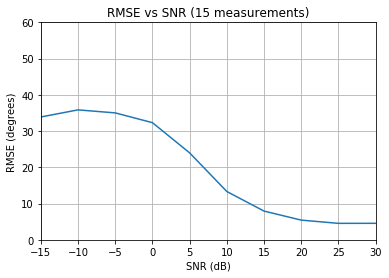

In [44]:
### Test the NN Model ###

for SNR_i in SNR:
    print("\n{} dB SNR --".format(SNR_i))
    test_pred_angles = model.predict(test_data_dict_r[SNR_i])
    print(test_pred_angles.shape)

    test_loss, test_mae, test_mse = model.evaluate(test_data_dict_r[SNR_i],  test_labels_dict_r[SNR_i], verbose=2)
    print('\tTest MSE:', test_mse)
    
    ## Compute the RMSE of the angles
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(test_angles_dict_r[SNR_i], test_pred_angles)
    rmse_keras = m.result().numpy()
    print('\tKeras RMSE: ', rmse_keras)
    
    RMSE_reg[SNR_i] = rmse_keras

    # Compute the predicted labels and the confusion matrix
#     test_pred_labels = np.argmax(test_predictions, 1)
#     test_confusion = tf.math.confusion_matrix(test_labels_dict[SNR_i],
#                                               test_pred_labels)
#     print(test_confusion)
#     class_confusionMat[SNR_i] = test_confusion

    ## Plot the confusion matrix (see which beams get associated with each other)
#     fig, ax = plt.subplots()
#     ax.matshow(test_confusion)
#     for (i, j), z in np.ndenumerate(test_confusion):
#         ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

#     ax.set_xticklabels(CLASSES)
#     ax.set_yticklabels(CLASSES)
#     ax.xaxis.set_label_position("top")
#     fig.set_size_inches(12, 12)
#     plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
#     plt.xlabel("Predicted angles (degrees)")
#     plt.ylabel("True angles (degrees)")
#     plt.xticks(np.arange(NUM_CLASSES))
#     plt.yticks(np.arange(NUM_CLASSES))
#     plt.savefig('../figures/confusionMatrix_reg_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
#     plt.show()

print("Number of results: {}".format(len(RMSE_reg)))

# Store the results
#all_test_acc[NUM_MEAS] = class_test_acc
all_RMSE_reg[NUM_MEAS] = RMSE_reg

# Plot of accuracy vs. SNR
# plt.figure()
# plt.plot(SNR, list(class_test_acc.values()))
# plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(RMSE_reg.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)

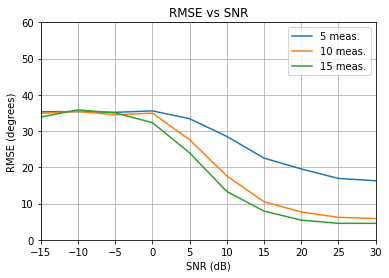

In [45]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_RMSE_reg.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
# plt.figure()
# for i in np.arange(NUM_PLOTS):
#     plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
# plt.title("Test Accuracy vs SNR")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)
# plt.legend(label_plots)
# plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_reg[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_reg_rmse.png')


In [46]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
#     all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
#     all_test_res.insert(loc=int(i), 
#                         column="Accuracy_{}".format(label_plots[i]),
#                         value=all_test_acc_np)
    all_rmse_reg_np = np.array(list(all_RMSE_reg[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_reg_np)

print(all_test_res)
all_test_res.to_csv("../data/regression_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.
-15     35.328289      34.888290      33.889206
-10     35.379852      35.416080      35.851391
-5      35.181820      34.488541      35.018875
 0      35.573147      34.953278      32.322292
 5      33.409790      27.597979      23.989941
 10     28.529898      17.621866      13.325187
 15     22.547327      10.511057       7.925580
 20     19.561069       7.668045       5.431944
 25     16.929165       6.201704       4.540309
 30     16.294001       5.887393       4.549653
